# Plotting Summary
Sherry Wong, 9 June 2021


This notebook serves the purpose of consolidating all code from Fall 2020-2021.

## 1. Plotting in Matplotlib

### 1.1 Read/load files
#### Save as .csv

### 1.2 Coordinate Setup
### 1.3 Data Setup
### 1.4 Zooming
### 1.5 Velocity Vector Fields

## 2. Plotting with YT
### 2.1 Zooming (w/ + w/o Cut Regions)
### 2.2 Velocity Vector Fields
### 2.3 Streamlines
### 2.4 Making gifs
### 2.5 Total Mass

### Import relevant packages:

In [1]:
import yt
from yt.units import kpc #for yt unit

import os #for file navigation
import os.path
from os import path

import shutil #remove excess files
import time #record runtime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm #for log scale

import moviepy #for gif making
from moviepy.editor import ImageSequenceClip #for gif making
import beepy #sound for when the code is done running
import numpy as np #for working with numbers


## 1. Plotting in Matplotlib
### 1.1 Read/load files:

In [2]:
import h5py

#This method reads in a file, and creates a dictionary of relevant variables.
def fileInputTest(fileName):
    f2 = h5py.File(fileName, 'r')

    print("\nReading file:")
    print(f2) #general info
    print(f2.attrs)
    print("\nKeys:")
    print(f2.keys())
    print()

    coords = f2['coordinates']
    cray = f2['cray']
    dens = f2['dens']
    magx = f2['magx']
    magy = f2['magy']
    magz = f2['magz']
    pres = f2['pres']
    velx = f2['velx']
    vely = f2['vely']
    velz = f2['velz']
    temp = f2['temp']

    dict = {
        "coordinates" : coords,
        "cray_pressure" : cray,
        "density" : dens,
        "magx" : magx,
        "magy" : magy,
        "magz" : magz,
        "pressure" : pres,
        "velx" : velx,
        "vely" : vely,
        "velz" : velz,
        "temp" : temp

    }
    return dict
    #END OF METHOD

#Full file path. Jupyter likes Windows notation, Spyder likes Mac/Linux
#Change the filename to see a different simulation time
filename = r"C:\Users\wongb\Documents\URS Data\m2_c1_16x8_64x64/More Plot Files/parkerCRs_hdf5_plt_cnt_0076"
#filename = "/mnt/c/Users/wongb/Documents/URS Data/m1.5_c1_16x16_128x128_Rodrigues_Streaming/More Plot Files/parkerCRs_hdf5_plt_cnt_0000"

dict = fileInputTest(filename)

#print(dict)
#print(dict['density'])


Reading file:
<HDF5 file "parkerCRs_hdf5_plt_cnt_0076" (mode r)>
<Attributes of HDF5 object at 2680476001680>

Keys:
<KeysViewHDF5 ['bflags', 'block size', 'bounding box', 'coordinates', 'cray', 'dens', 'gid', 'gsurr_blks', 'integer runtime parameters', 'integer scalars', 'logical runtime parameters', 'logical scalars', 'magx', 'magy', 'magz', 'node type', 'pres', 'processor number', 'real runtime parameters', 'real scalars', 'refine level', 'sim info', 'string runtime parameters', 'string scalars', 'temp', 'unknown names', 'velx', 'vely', 'velz', 'which child']>



#### Save as .csv if necessary
Commented out b/c data arrays haven't yet been initialised in the notebook, which will cause an error.

In [3]:
import csv #https://docs.python.org/3/library/csv.html#csv.Dialect

#write files for easier access later
#with open('m2_c1_0000_data.csv', 'w', newline='') as csvfile:
# fieldnames = ['posx', 'posy', 'velx', 'vely', 'mag', 'density']
# writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
# writer.writeheader()

# for i in range(0, 262143):
#     writer.writerow({'posx': posXarray[i], 'posy': posYarray[i], 
#                      'velx': velXarray[i], 'vely': velYarray[i], 
#                      'mag': color[i], 'density': densityArray[i]})

### 1.2 Coordinate Setup
#### Prelude:

The coordinate system for the FLASH simulation is a Z-order curve. It doesn't matter too much for our purposes, but it looks cool:

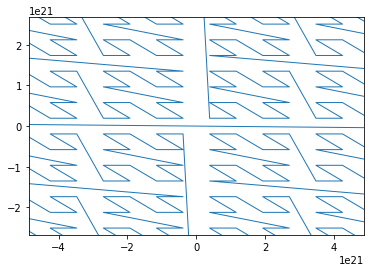

In [4]:
#recreate the z-order curve:
posX = [] #list
posY = [] #list
for coord in dict['coordinates']:
    posX.append(coord[0])
    posY.append(coord[1])
plt.plot(posX, posY, linewidth = 1)
plt.margins(x=-0.4, y=-0.39) #zoom
#plt.savefig('CoordPlot1.png'); #bad quality
#plt.savefig('CoordPlot1.svg'); #much better quality
###print("\nPlotting finished.")

#### Expanding coordinate grid

<img src="Data_8x8.png" width="300" style="float: right; padding-left: 30px">

The way that the data is set up, each single coordinate represents a 8x8 box of additional data points. Thus, in order to view the full resolution, it is necessary to expand the each coordinate into an 8x8 grid, with the original coordinate in the bottom left corner. The other data will populate these 8x8 grids.


Without this extra work, plots will be much less resolved:

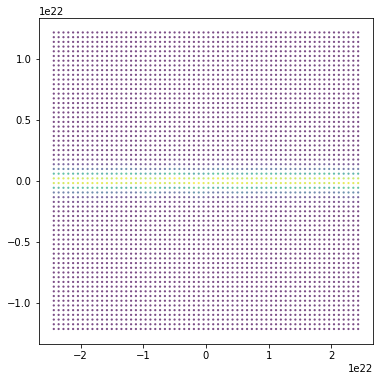

In [5]:
#First convert the HDF5 data into lists
posX = [] #list
posY = [] #list
for coord in dict['coordinates']:
    posX.append(coord[0])
    posY.append(coord[1])
    
density = [] #list
for dens in dict['density']:
     #a random point in the 8x8
    density.append(dens[0][4][4])
    
fig = plt.figure(figsize=(6, 6))
plt.scatter(posX, posY,
           linewidths=0, alpha=.7,
           edgecolor='k',
           s = 5,
           c=density)

#### Coordinate Setup Code
Lets do this properly. 

For each single XY point, we will create an 8x8 grid with the specified point in the bottom left (see image in expanding coordinate grid). Then we will flatten the grid to get two 1D XY arrays. We will calculate the offset based on the position of neighboring cells.

In [6]:
"""Sets up coordinates for 16384 * 64 data points."""
posX = [] #list
posY = [] #list
#these steps may differ between simulations
stepX = dict['coordinates'][1][0] - dict['coordinates'][0][0]
stepY = dict['coordinates'][2][1] - dict['coordinates'][1][1]

for coord in dict['coordinates']:
    
    #equally space x and y apart
    tempXlin = np.linspace(coord[0], coord[0] + stepX, 8)
    tempYlin = np.linspace(coord[1], coord[1] + stepY, 8)
    
    #create a grid of coordinates using these XY values
    tempMeshgrid = np.meshgrid(tempXlin, tempYlin)
    
    #append the full X and Y coordinate pairs
    posX.append(tempMeshgrid[0])
    posY.append(tempMeshgrid[1])
    
posXarray, posYarray = (np.asarray(posX), np.asarray(posY))
posXarray = posXarray.flatten()
posYarray = posYarray.flatten()

### 1.3 Data Setup
Now let's set up the actual data and load them into arrays. These don't require extra work; they are already expanded.

In [32]:
"""Density Setup"""
density = [] #list
for dens in dict['density']:
    density.append(dens) #shape=(1, 8, 8)
densityArray = np.asarray(density)
densityArray = densityArray.flatten()

""""Temp Setup"""
temp = [] #list
for thing in dict['temp']:
    temp.append(thing) #shape=(1, 8, 8)
tempArray = np.asarray(temp)
tempArray = tempArray.flatten()

"""Velocity Setup"""
velX = []
velY = []
for x in dict['velx']:
    velX.append(x)
for y in dict['vely']:
    velY.append(y)
velXarray = np.asarray(velX)
velYarray = np.asarray(velY)
velXarray = velXarray.flatten()
velYarray = velYarray.flatten()

Now we are ready to plot our data.

In [31]:
plt.title("Density (g/cm^3)")
plt.tricontourf(posXarray, posYarray, densityArray, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.colorbar(extend='both', orientation='vertical')

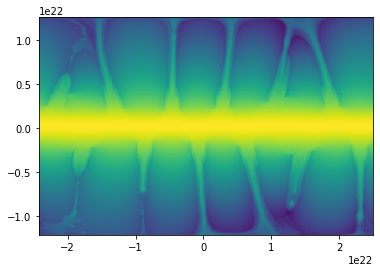

In [9]:
z=densityArray
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarray, posYarray, z, locator=ticker.LogLocator(), levels = lev) #good for irregular Z values

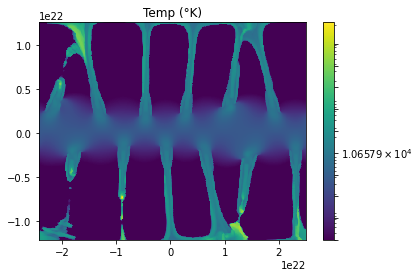

In [10]:
z=tempArray
plt.title("Temp (\N{DEGREE SIGN}K)")
# plt.title("Density (g/$cm^3$)")

lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarray, posYarray, z, locator=ticker.LogLocator(), levels = lev) #good for irregular Z values
plt.colorbar(extend='both', orientation='vertical')

### 1.4 Zooming in matplotlib
We can zoom into particular sections of a plot by applying limits to the data.

In [11]:
#The true/false table
TFtable = np.logical_and((pow(10, 22) < posXarray), (posYarray < 0))

#apply the true/false table to our data.
posXarrayZoom = posXarray[TFtable]
posYarrayZoom = posYarray[TFtable]
velXarrayZoom = velXarray[TFtable]
velYarrayZoom = velYarray[TFtable]
densityArrayZoom = densityArray[TFtable]
tempArrayZoom = tempArray[TFtable]

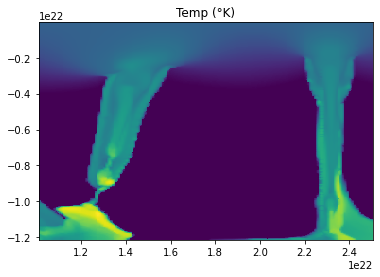

In [12]:
z=tempArrayZoom
plt.title("Temp (\N{DEGREE SIGN}K)")
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarrayZoom, posYarrayZoom, z, locator=ticker.LogLocator(), levels = lev)

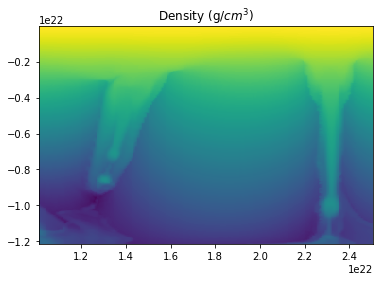

In [13]:
z=densityArrayZoom
plt.title("Density (g/$cm^3$)")
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarrayZoom, posYarrayZoom, z, locator=ticker.LogLocator(), levels = lev)

### 1.5 Velocity Vector Plots
Matplotlib has a built-in way to make vector plots.

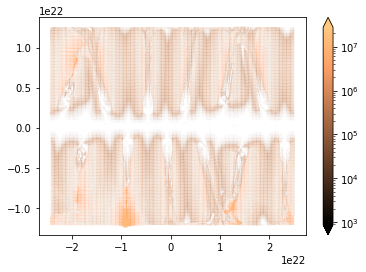

In [14]:
plt.clf
color = np.hypot(velXarray, velYarray)
#plt.tricontourf(posXarray, posYarray, densityArray, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.quiver(posXarray, posYarray, velXarray, velYarray, color, norm=matplotlib.colors.LogNorm(),
           width=0.001, minlength = 0.001, headwidth=0.25, headlength=0.5, 
            cmap = plt.get_cmap('copper'))
plt.colorbar(extend='both', orientation='vertical')

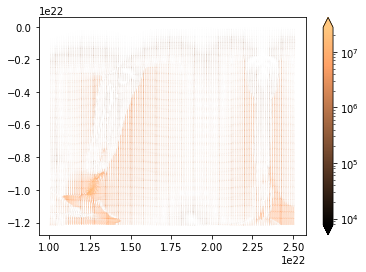

In [15]:
plt.clf
color = np.hypot(velXarrayZoom, velYarrayZoom)
#plt.tricontourf(posXarrayZoom, posYarrayZoom, densityArrayZoom, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.quiver(posXarrayZoom, posYarrayZoom, velXarrayZoom, velYarrayZoom, color, norm=matplotlib.colors.LogNorm(),
           width=0.001, minlength = 0.001, headwidth=0.25, headlength=0.5, 
            cmap = plt.get_cmap('copper'))
plt.colorbar(extend='both', orientation='vertical')

## 2. Plotting with YT
YT is a very powerful tool for plotting. Much of what we need can be more easily done in YT, but it is more difficult to fine-tune the back end of the data we feed into it.

It is *much* easier and cleaner to plot basic plots:

In [16]:
import yt
filename = r"C:\Users\wongb\Documents\URS Data\m2_c1_16x8_64x64/More Plot Files/parkerCRs_hdf5_plt_cnt_0076"
yt.toggle_interactivity() #Interactive plots?

Using matplotlib backend: Qt5Agg


yt : [INFO     ] 2021-06-18 16:08:03,811 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-06-18 16:08:03,814 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 16:08:03,816 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 16:08:03,818 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 16:08:03,821 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 16:08:06,011 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 16:08:06,014 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 16:08:06,018 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 16:08:06,020 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 16:08:06,022 Ma


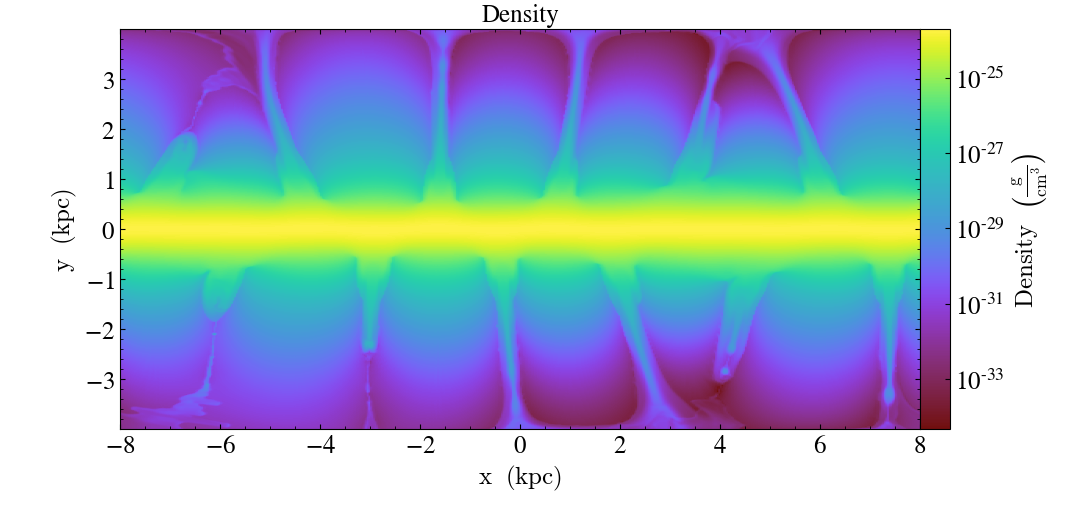

In [17]:
ds = yt.load(filename)
slc = yt.SlicePlot(ds, 'z', 'density')
slc.annotate_title("Density")

It is also easy to see all the included data:

In [18]:
for i in sorted(ds.field_list):
    print(i)
for i in sorted(ds.derived_field_list):
    print(i)

('flash', 'cray')
('flash', 'dens')
('flash', 'magx')
('flash', 'magy')
('flash', 'magz')
('flash', 'pres')
('flash', 'temp')
('flash', 'velx')
('flash', 'vely')
('flash', 'velz')
('flash', 'cell_volume')
('flash', 'cray')
('flash', 'dens')
('flash', 'dx')
('flash', 'dy')
('flash', 'dz')
('flash', 'magx')
('flash', 'magy')
('flash', 'magz')
('flash', 'path_element_x')
('flash', 'path_element_y')
('flash', 'path_element_z')
('flash', 'pres')
('flash', 'temp')
('flash', 'velx')
('flash', 'vely')
('flash', 'velz')
('flash', 'vertex_x')
('flash', 'vertex_y')
('flash', 'vertex_z')
('flash', 'x')
('flash', 'y')
('flash', 'z')
('gas', 'H_nuclei_density')
('gas', 'He_nuclei_density')
('gas', 'alfven_speed')
('gas', 'angular_momentum_magnitude')
('gas', 'angular_momentum_x')
('gas', 'angular_momentum_y')
('gas', 'angular_momentum_z')
('gas', 'averaged_density')
('gas', 'baroclinic_vorticity_magnitude')
('gas', 'baroclinic_vorticity_x')
('gas', 'baroclinic_vorticity_y')
('gas', 'baroclinic_vorti

### 2.1 Zooming in YT
With some guesswork (on plot centres), it is also easy to zoom into a part of the plot:

yt : [INFO     ] 2021-06-18 17:43:16,188 xlim = 3.100000 5.100000
yt : [INFO     ] 2021-06-18 17:43:16,190 ylim = -3.850000 -1.850000
yt : [INFO     ] 2021-06-18 17:43:16,193 xlim = 9565600500983204413440.000000 15736955662907853504512.000000
yt : [INFO     ] 2021-06-18 17:43:16,195 ylim = -11879858686704949919744.000000 -5708503524780300828672.000000
yt : [INFO     ] 2021-06-18 17:43:16,198 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-18 17:43:18,244 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



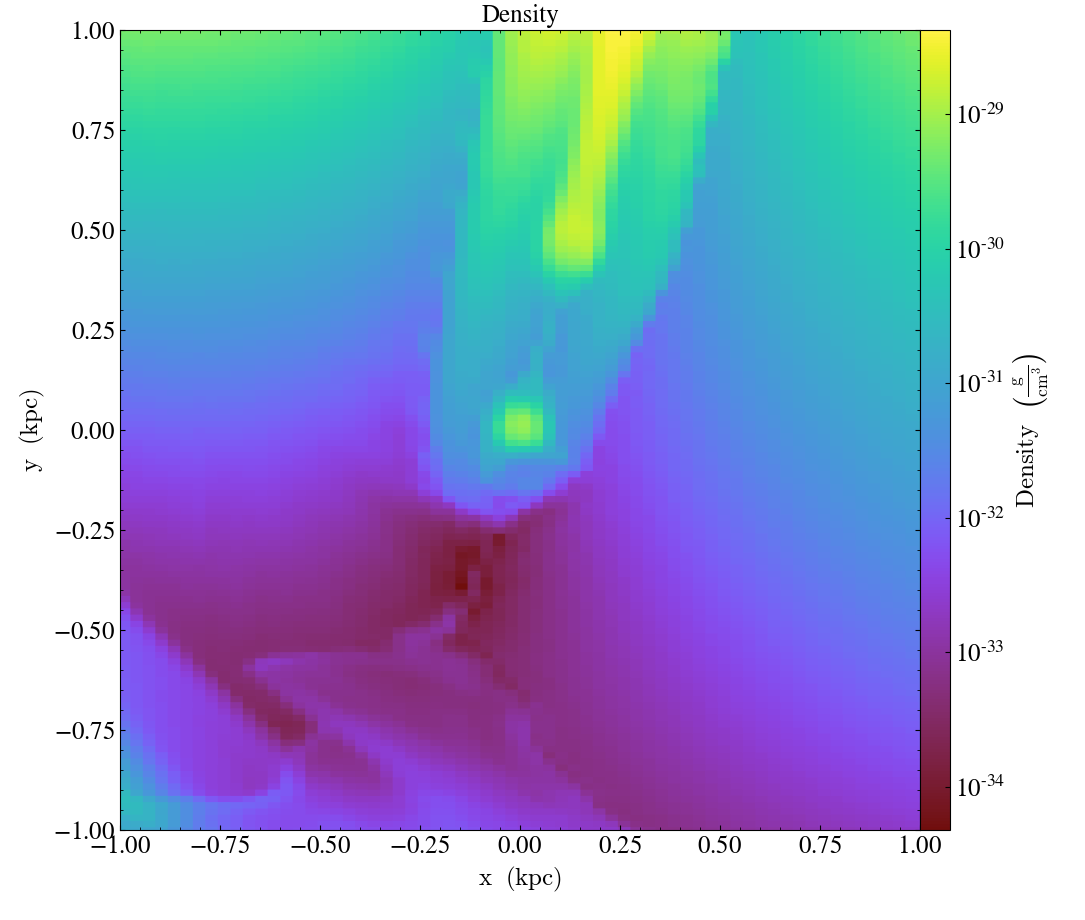

In [19]:
slc = yt.SlicePlot(ds, 'z', 'density', center=(4.1*kpc, -2.85*kpc, 0), width=(2*kpc, 2*kpc, 0)) #3D!!!
slc.set_width(2*kpc)
slc.annotate_title("Density")

Generally, this zooming strategy is janky and only works to navigate premade large plots. It is more difficult to, for example, select and examine the data only contained in the above box. The way to do this is to use YT Cut Regions.

yt : [INFO     ] 2021-06-18 17:43:27,133 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 17:43:27,134 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 17:43:27,135 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 17:43:27,136 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 17:43:27,137 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-18 17:43:27,473 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



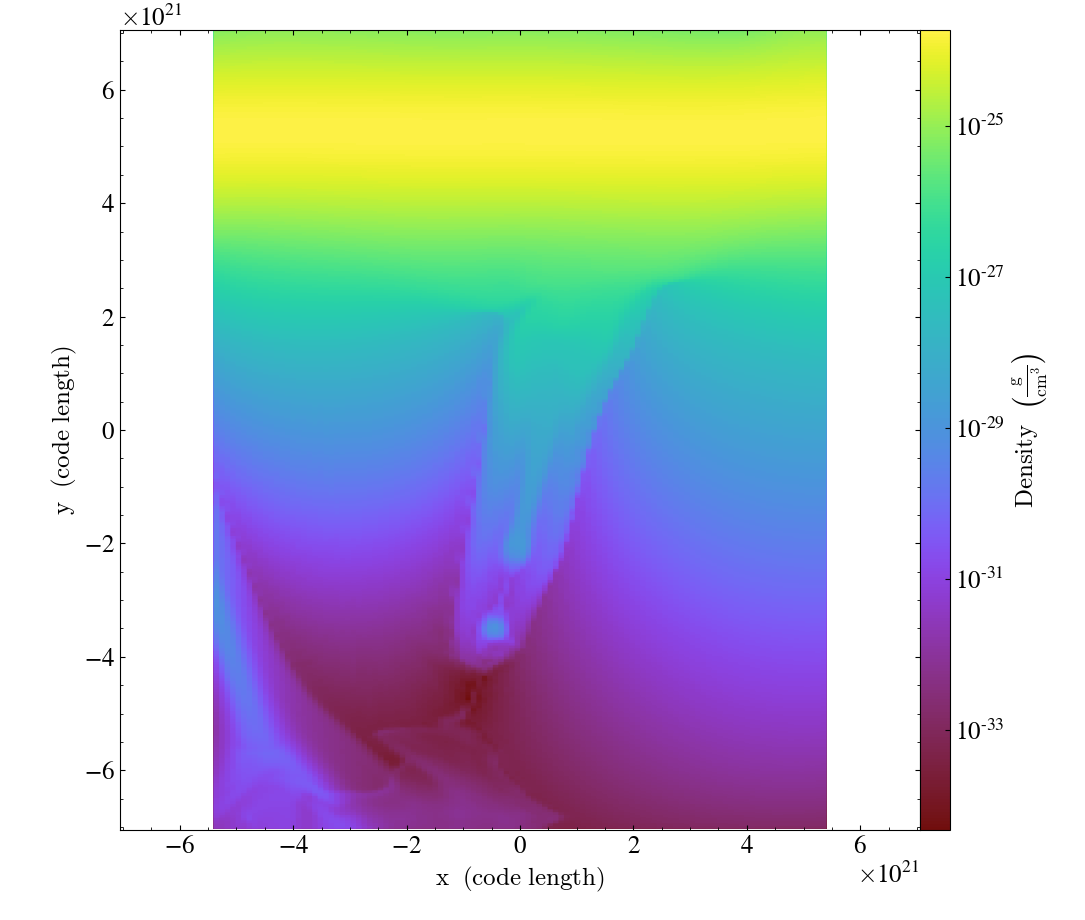

In [20]:
ad = ds.all_data()
conversion = 3.086e21 #kpc to cm
bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': 1.79040182984184e21}
dsSelect = ad.include_inside('x', bounds['xmin'], bounds['xmax'])
dsSelect = dsSelect.include_inside('y', bounds['ymin'], bounds['ymax'])
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))

Using a Cut Region allows us to manipulate the data that exists ONLY within these boundaries.

yt : [INFO     ] 2021-06-18 21:06:44,429 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-06-18 21:06:44,430 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 21:06:44,433 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 21:06:44,434 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 21:06:44,435 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 21:06:52,494 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 21:06:52,495 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-06-18 21:06:52,496 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 21:06:52,496 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-06-18 21:06:52,498 Maki


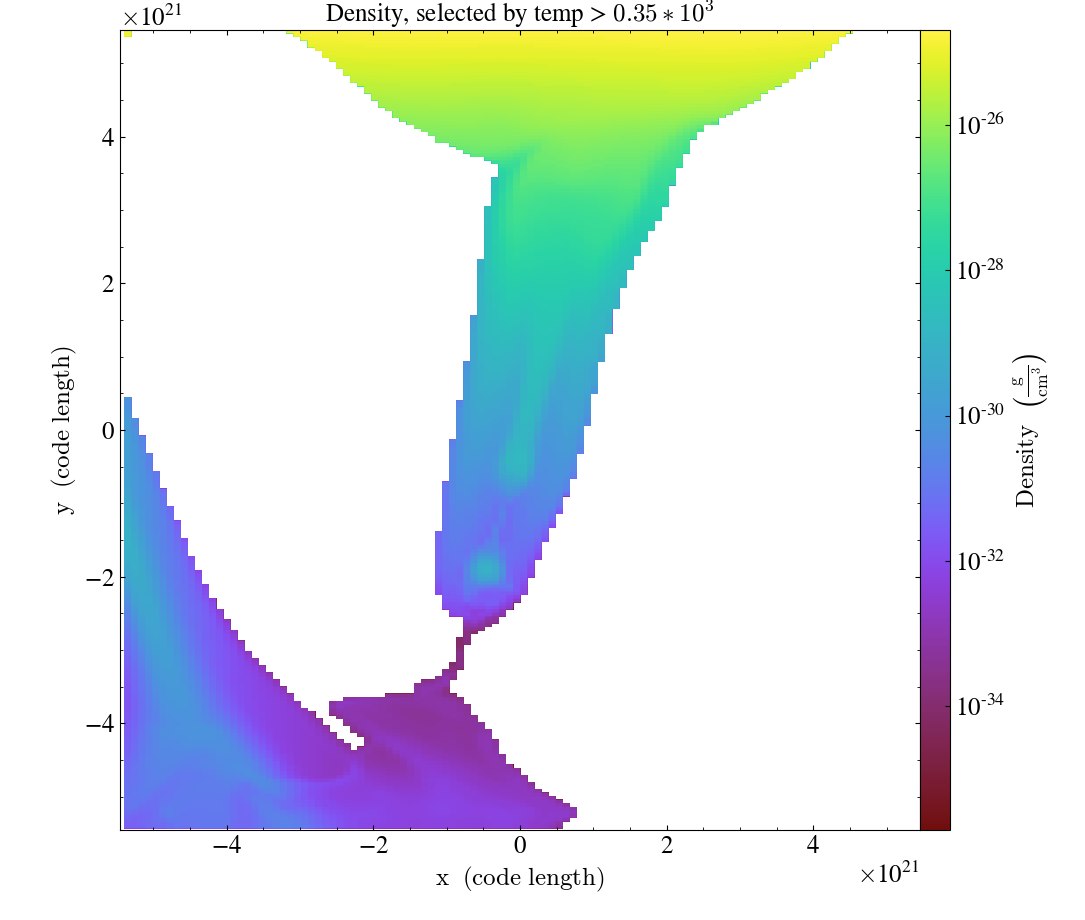

In [37]:
ds = yt.load(filename)
ad = ds.all_data()
# bounds = {'xmin': -0.3e+22, 'xmax': 0.22e+22, 'ymin': min(ad['y']).value,'ymax': 0}
conversion = 3.086e21 #kpc-->cm
# bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': 0}
bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': -1.40477660814861e21}

dsSelect = ad.include_inside('x', bounds['xmin'], bounds['xmax'])
dsSelect = dsSelect.include_inside('y', bounds['ymin'], bounds['ymax'])
dsSelect = dsSelect.cut_region("obj['temp'] > .25*10e3")
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                    center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
# slc.set_width(-min(ad['y']))

# dsSelect = ad.cut_region("obj['temp'] > .35*10e3")
# slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect)

# slc.set_ylim('y', min(ad['y']), 0)
slc.annotate_title("Density, selected by temp > $0.25*10^3$")

### 2.2 Velocity Vector Fields
YT has a built-in vector field plotting function.

yt : [INFO     ] 2021-06-18 17:43:28,095 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 17:43:28,096 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 17:43:28,097 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 17:43:28,098 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 17:43:28,102 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-18 17:43:28,442 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



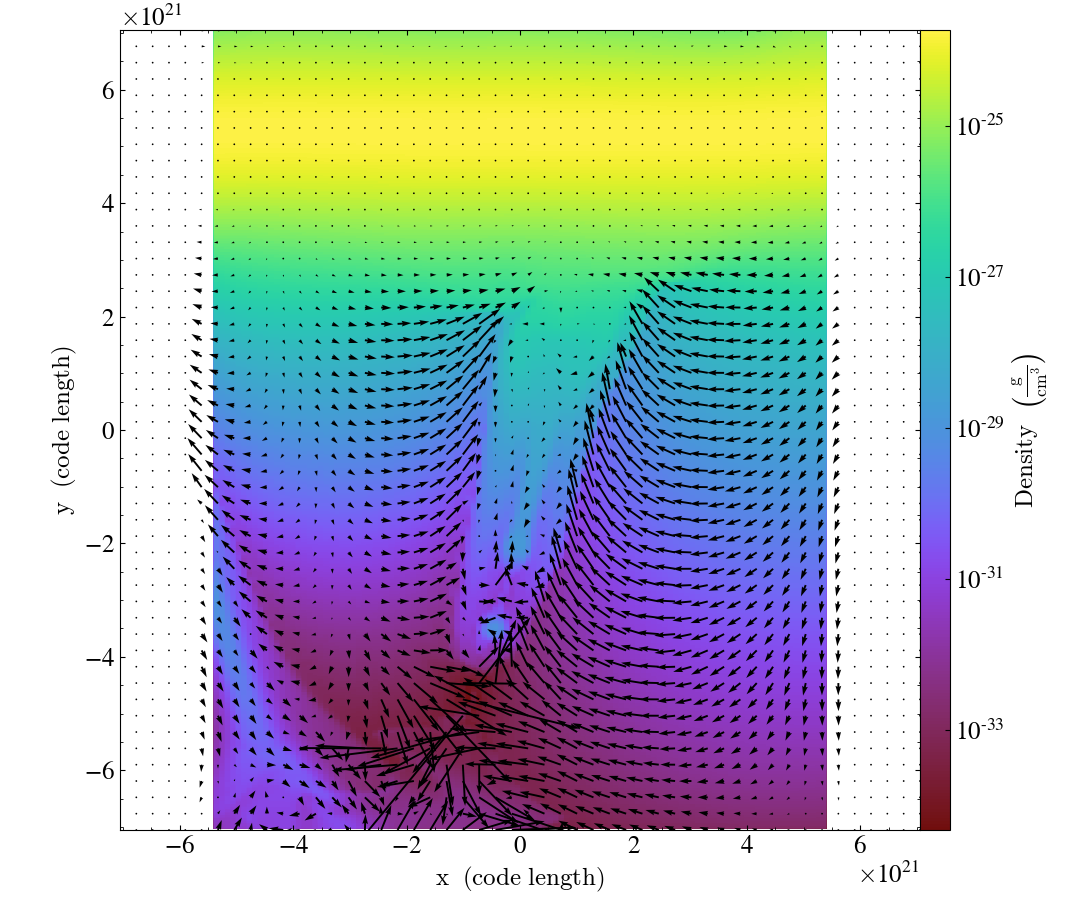

In [21]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_velocity(factor=16)

### 2.3 Streamlines
Streamlines allow us to more easily see trends in the vector fields:

yt : [INFO     ] 2021-06-18 17:43:29,264 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 17:43:29,265 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 17:43:29,266 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 17:43:29,266 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 17:43:29,268 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-18 17:43:29,695 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



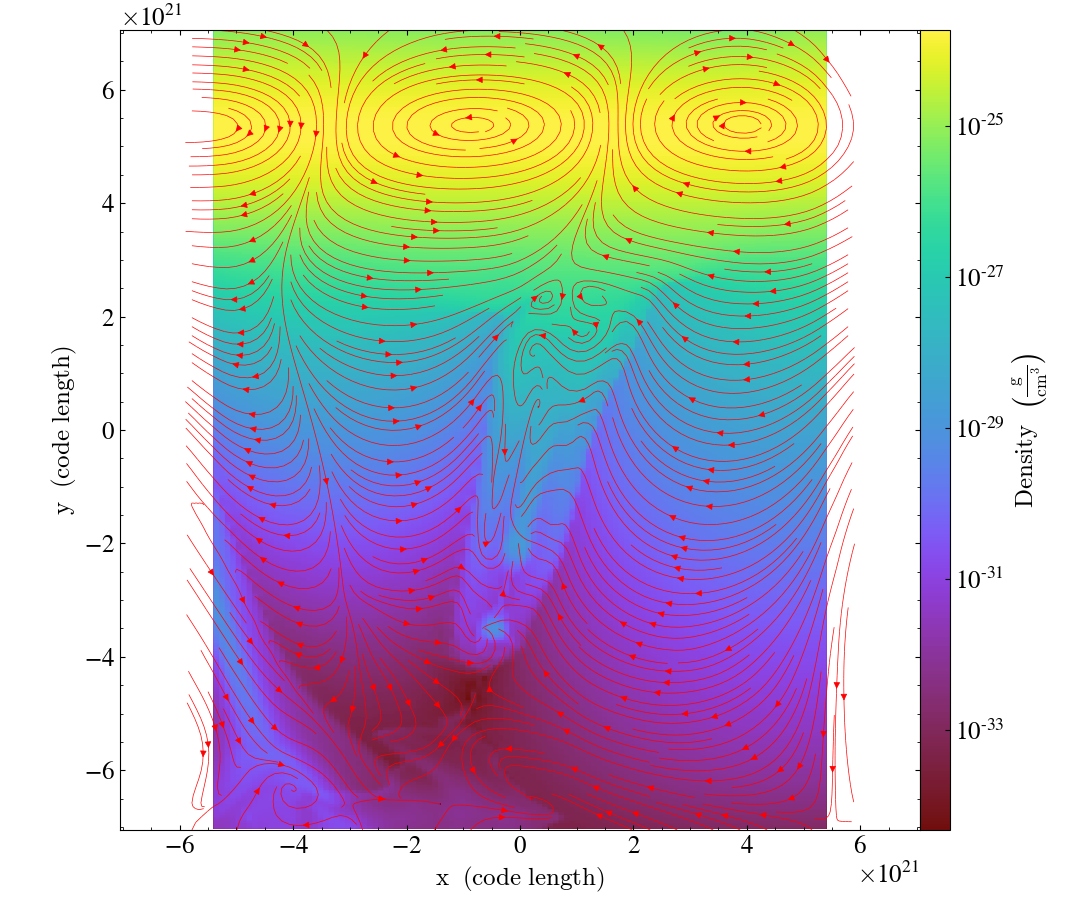

In [22]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_streamlines('velocity_x','velocity_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

We can do the same for the magnetic field in the system

yt : [INFO     ] 2021-06-18 18:50:52,545 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 18:50:52,546 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 18:50:52,547 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-18 18:50:52,547 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-18 18:50:52,549 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-18 18:50:52,849 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



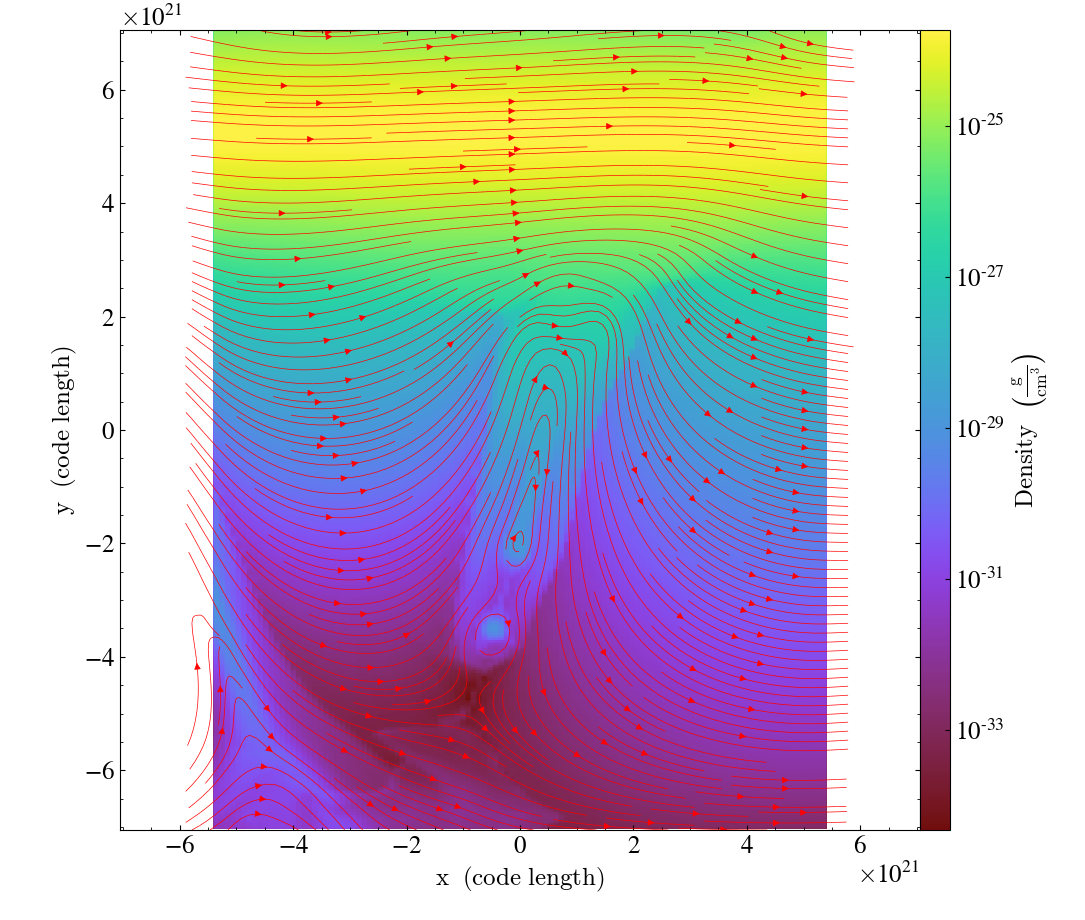

In [23]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_streamlines('magnetic_field_x','magnetic_field_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

### 2.4 Making Gifs
We can make gifs of the entire simulation by plotting information from every timestamp. then stitching them into a gif using an online tool like https://ezgif.com/maker or a python package moviepy.

Set your directory to the one containing your simulation output files. Set the save directory to where you want to save the many output image plots. Specify the field you want to plot. Expect this code to take a bit of time to run, about a few minutes.

In [24]:
directory = "/Users/wongb/Documents/URS Data/m2_c1_16x8_64x64/More Plot Files/"
saveDirectory = "D:/URS_LargeData/SherryPlots"

field = 'density'

In [25]:
startTime = time.time()
for fileName in os.listdir(directory):
    #Find all simulation files. These files all start with parkerCRs,
    #e.g. parkerCRs_hdf5_plt_cnt_0076
    if(fileName.startswith("parkerCRs")):
        #Start
        print(fileName)
        timeStamp = fileName[len(fileName)-4: len(fileName)]
        ds = yt.load(directory+fileName)
        
        #SlicePlot
        slc = yt.SlicePlot(ds, 'z', field)
        # slc.annotate_velocity(factor=16)
        slc.annotate_title(timeStamp +" "+ field)
        plot = slc.plots[field]
        slc.set_zlim('density', 1e-33, 1e-24)
        # slc.annotate_streamlines('magnetic_field_x','magnetic_field_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

        #Finish
        #https://stackabuse.com/creating-and-deleting-directories-with-python/
        #Create a new save folder if one does not exist already
        if (not path.exists(saveDirectory + "/" + field)):
            os.mkdir(saveDirectory + "/" + field)
            
        ### Enable the below line for the code to save anything;
        ### Disabled for the sake of jupyter
        # # slc.save(saveDirectory + "/" + field + "/" + timeStamp)
beepy.beep(4)
print()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Plotting done. Time elapsed (sec): " + str(time.time()-startTime))

parkerCRs_hdf5_plt_cnt_0000


yt : [INFO     ] 2021-06-18 18:50:55,798 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-06-18 18:50:55,799 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:50:55,801 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:50:55,801 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:50:55,803 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:50:57,765 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:50:57,766 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:50:57,767 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:50:57,768 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:50:57,769 Making a fixed resolu

parkerCRs_hdf5_plt_cnt_0001


yt : [INFO     ] 2021-06-18 18:50:58,991 Parameters: current_time              = 317264985381575.2
yt : [INFO     ] 2021-06-18 18:50:58,993 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:50:58,994 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:50:58,995 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:50:58,996 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:00,808 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:00,810 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:00,811 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:00,812 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:00,813 Making 

parkerCRs_hdf5_plt_cnt_0002


yt : [INFO     ] 2021-06-18 18:51:02,007 Parameters: current_time              = 631952027459833.6
yt : [INFO     ] 2021-06-18 18:51:02,007 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:02,008 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:02,009 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:02,010 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:03,756 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:03,757 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:03,758 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:03,759 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:03,760 Making 

parkerCRs_hdf5_plt_cnt_0003


yt : [INFO     ] 2021-06-18 18:51:05,411 Parameters: current_time              = 947866814238225.9
yt : [INFO     ] 2021-06-18 18:51:05,412 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:05,413 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:05,414 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:05,416 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:07,618 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:07,619 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:07,621 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:07,622 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:07,624 Making 

parkerCRs_hdf5_plt_cnt_0004


yt : [INFO     ] 2021-06-18 18:51:08,972 Parameters: current_time              = 1262476539434951.2
yt : [INFO     ] 2021-06-18 18:51:08,974 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:08,977 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:08,979 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:08,981 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:12,017 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:12,018 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:12,020 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:12,022 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:12,024 Making

parkerCRs_hdf5_plt_cnt_0005


yt : [INFO     ] 2021-06-18 18:51:13,549 Parameters: current_time              = 1578266342968121.8
yt : [INFO     ] 2021-06-18 18:51:13,550 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:13,550 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:13,552 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:13,553 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:15,666 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:15,667 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:15,670 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:15,671 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:15,673 Making

parkerCRs_hdf5_plt_cnt_0006


yt : [INFO     ] 2021-06-18 18:51:17,533 Parameters: current_time              = 1893515688749212.5
yt : [INFO     ] 2021-06-18 18:51:17,534 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:17,536 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:17,538 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:17,539 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:20,179 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:20,180 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:20,182 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:20,183 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:20,184 Making

parkerCRs_hdf5_plt_cnt_0007


yt : [INFO     ] 2021-06-18 18:51:21,343 Parameters: current_time              = 2209164029823500.8
yt : [INFO     ] 2021-06-18 18:51:21,344 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:21,345 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:21,346 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:21,346 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:22,955 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:22,957 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:22,958 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:22,959 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:22,962 Making

parkerCRs_hdf5_plt_cnt_0008


yt : [INFO     ] 2021-06-18 18:51:24,147 Parameters: current_time              = 2525184311118510.5
yt : [INFO     ] 2021-06-18 18:51:24,148 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:24,148 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:24,150 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:24,151 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:26,389 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:26,389 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:26,391 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:26,392 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:26,393 Making

parkerCRs_hdf5_plt_cnt_0009


yt : [INFO     ] 2021-06-18 18:51:27,555 Parameters: current_time              = 2840503028998597.0
yt : [INFO     ] 2021-06-18 18:51:27,556 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:27,557 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:27,558 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:27,560 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:29,284 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:29,285 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:29,286 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:29,287 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:29,289 Making

parkerCRs_hdf5_plt_cnt_0010


yt : [INFO     ] 2021-06-18 18:51:30,500 Parameters: current_time              = 3155862236714411.5
yt : [INFO     ] 2021-06-18 18:51:30,501 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:30,502 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:30,504 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:30,505 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:32,803 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:32,804 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:32,805 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:32,806 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:32,807 Making

parkerCRs_hdf5_plt_cnt_0011


yt : [INFO     ] 2021-06-18 18:51:33,842 Parameters: current_time              = 3471268345709315.0
yt : [INFO     ] 2021-06-18 18:51:33,842 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:33,843 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:33,844 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:33,845 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:35,317 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:35,318 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:35,319 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:35,320 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:35,321 Making

parkerCRs_hdf5_plt_cnt_0012


yt : [INFO     ] 2021-06-18 18:51:36,517 Parameters: current_time              = 3786142643652690.5
yt : [INFO     ] 2021-06-18 18:51:36,518 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:36,519 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:36,521 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:36,523 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:39,094 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:39,095 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:39,096 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:39,097 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:39,099 Making

parkerCRs_hdf5_plt_cnt_0013


yt : [INFO     ] 2021-06-18 18:51:40,278 Parameters: current_time              = 4102175170351167.0
yt : [INFO     ] 2021-06-18 18:51:40,280 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:40,282 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:40,283 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:40,285 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:41,780 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:41,781 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:41,782 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:41,783 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:41,785 Making

parkerCRs_hdf5_plt_cnt_0014


yt : [INFO     ] 2021-06-18 18:51:42,821 Parameters: current_time              = 4417602849178326.0
yt : [INFO     ] 2021-06-18 18:51:42,822 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:42,822 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:42,823 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:42,824 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:44,898 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:44,899 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:44,900 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:44,901 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:44,902 Making

parkerCRs_hdf5_plt_cnt_0015


yt : [INFO     ] 2021-06-18 18:51:46,119 Parameters: current_time              = 4733224019000497.0
yt : [INFO     ] 2021-06-18 18:51:46,120 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:46,121 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:46,121 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:46,122 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:47,922 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:47,924 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:47,925 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:47,926 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:47,928 Making

parkerCRs_hdf5_plt_cnt_0016


yt : [INFO     ] 2021-06-18 18:51:49,160 Parameters: current_time              = 5048681019761606.0
yt : [INFO     ] 2021-06-18 18:51:49,161 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:49,163 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:49,164 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:49,165 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:52,041 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:52,043 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:52,044 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:52,045 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:52,046 Making

parkerCRs_hdf5_plt_cnt_0017


yt : [INFO     ] 2021-06-18 18:51:53,327 Parameters: current_time              = 5363547157835992.0
yt : [INFO     ] 2021-06-18 18:51:53,328 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:53,329 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:53,330 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:53,331 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:55,363 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:55,364 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:55,365 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:55,366 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:55,368 Making

parkerCRs_hdf5_plt_cnt_0018


yt : [INFO     ] 2021-06-18 18:51:56,726 Parameters: current_time              = 5679631097980939.0
yt : [INFO     ] 2021-06-18 18:51:56,727 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:51:56,728 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:56,729 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:51:56,731 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:51:58,933 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:58,934 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:58,935 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:51:58,936 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:51:58,937 Making

parkerCRs_hdf5_plt_cnt_0019


yt : [INFO     ] 2021-06-18 18:52:00,099 Parameters: current_time              = 5994622447803141.0
yt : [INFO     ] 2021-06-18 18:52:00,100 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:00,101 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:00,102 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:00,103 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:01,540 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:01,541 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:01,542 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:01,543 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:01,545 Making

parkerCRs_hdf5_plt_cnt_0020


yt : [INFO     ] 2021-06-18 18:52:02,654 Parameters: current_time              = 6310249420236883.0
yt : [INFO     ] 2021-06-18 18:52:02,655 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:02,656 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:02,657 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:02,658 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:04,669 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:04,670 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:04,672 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:04,672 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:04,674 Making

parkerCRs_hdf5_plt_cnt_0021


yt : [INFO     ] 2021-06-18 18:52:05,710 Parameters: current_time              = 6626053871755637.0
yt : [INFO     ] 2021-06-18 18:52:05,711 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:05,712 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:05,713 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:05,714 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:07,919 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:07,921 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:07,922 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:07,923 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:07,925 Making

parkerCRs_hdf5_plt_cnt_0022


yt : [INFO     ] 2021-06-18 18:52:08,940 Parameters: current_time              = 6941478479349975.0
yt : [INFO     ] 2021-06-18 18:52:08,940 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:08,941 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:08,942 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:08,943 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:10,444 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:10,446 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:10,447 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:10,448 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:10,449 Making

parkerCRs_hdf5_plt_cnt_0023


yt : [INFO     ] 2021-06-18 18:52:11,510 Parameters: current_time              = 7256577386579009.0
yt : [INFO     ] 2021-06-18 18:52:11,511 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:11,511 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:11,512 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:11,513 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:13,424 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:13,425 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:13,426 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:13,427 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:13,428 Making

parkerCRs_hdf5_plt_cnt_0024


yt : [INFO     ] 2021-06-18 18:52:14,455 Parameters: current_time              = 7572229093200924.0
yt : [INFO     ] 2021-06-18 18:52:14,455 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:14,456 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:14,457 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:14,457 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:16,033 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:16,034 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:16,035 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:16,036 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:16,037 Making

parkerCRs_hdf5_plt_cnt_0025


yt : [INFO     ] 2021-06-18 18:52:17,092 Parameters: current_time              = 7887827062386465.0
yt : [INFO     ] 2021-06-18 18:52:17,092 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:17,093 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:17,095 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:17,096 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:19,200 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:19,202 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:19,203 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:19,204 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:19,205 Making

parkerCRs_hdf5_plt_cnt_0026


yt : [INFO     ] 2021-06-18 18:52:20,406 Parameters: current_time              = 8203329937430825.0
yt : [INFO     ] 2021-06-18 18:52:20,407 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:20,408 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:20,409 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:20,411 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:22,474 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:22,475 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:22,476 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:22,477 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:22,479 Making

parkerCRs_hdf5_plt_cnt_0027


yt : [INFO     ] 2021-06-18 18:52:23,741 Parameters: current_time              = 8518519234860240.0
yt : [INFO     ] 2021-06-18 18:52:23,742 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:23,743 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:23,745 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:23,746 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:26,143 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:26,144 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:26,145 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:26,146 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:26,147 Making

parkerCRs_hdf5_plt_cnt_0028


yt : [INFO     ] 2021-06-18 18:52:27,378 Parameters: current_time              = 8834271158348738.0
yt : [INFO     ] 2021-06-18 18:52:27,379 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:27,379 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:27,381 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:27,382 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:28,914 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:28,915 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:28,916 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:28,917 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:28,918 Making

parkerCRs_hdf5_plt_cnt_0029


yt : [INFO     ] 2021-06-18 18:52:29,986 Parameters: current_time              = 9149837787380592.0
yt : [INFO     ] 2021-06-18 18:52:29,987 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:29,987 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:29,988 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:29,990 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:32,013 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:32,014 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:32,015 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:32,016 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:32,017 Making

parkerCRs_hdf5_plt_cnt_0030


yt : [INFO     ] 2021-06-18 18:52:33,028 Parameters: current_time              = 9465119457627122.0
yt : [INFO     ] 2021-06-18 18:52:33,028 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:33,030 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:33,031 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:33,032 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:35,125 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:35,127 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:35,129 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:35,131 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:35,133 Making

parkerCRs_hdf5_plt_cnt_0031


yt : [INFO     ] 2021-06-18 18:52:36,679 Parameters: current_time              = 9780801276201566.0
yt : [INFO     ] 2021-06-18 18:52:36,680 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:36,681 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:36,682 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:36,684 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:38,972 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:38,973 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:38,974 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:38,975 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:38,976 Making

parkerCRs_hdf5_plt_cnt_0032


yt : [INFO     ] 2021-06-18 18:52:40,192 Parameters: current_time              = 1.0096336549334428e+16
yt : [INFO     ] 2021-06-18 18:52:40,193 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:40,194 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:40,195 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:40,196 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:41,602 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:41,604 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:41,605 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:41,606 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:41,607 Ma

parkerCRs_hdf5_plt_cnt_0033


yt : [INFO     ] 2021-06-18 18:52:42,618 Parameters: current_time              = 1.041153857414739e+16
yt : [INFO     ] 2021-06-18 18:52:42,619 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:42,620 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:42,621 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:42,622 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:44,656 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:44,657 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:44,659 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:44,660 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:44,661 Mak

parkerCRs_hdf5_plt_cnt_0034


yt : [INFO     ] 2021-06-18 18:52:45,671 Parameters: current_time              = 1.072729219785138e+16
yt : [INFO     ] 2021-06-18 18:52:45,672 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:45,672 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:45,673 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:45,674 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:47,074 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:47,075 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:47,076 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:47,077 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:47,078 Mak

parkerCRs_hdf5_plt_cnt_0035


yt : [INFO     ] 2021-06-18 18:52:48,749 Parameters: current_time              = 1.1042583708555828e+16
yt : [INFO     ] 2021-06-18 18:52:48,750 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:48,750 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:48,752 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:48,753 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:50,177 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:50,178 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:50,179 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:50,180 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:50,181 Ma

parkerCRs_hdf5_plt_cnt_0036


yt : [INFO     ] 2021-06-18 18:52:51,204 Parameters: current_time              = 1.1358074478540658e+16
yt : [INFO     ] 2021-06-18 18:52:51,205 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:51,205 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:51,206 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:51,207 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:53,242 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:53,243 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:53,244 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:53,245 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:53,246 Ma

parkerCRs_hdf5_plt_cnt_0037


yt : [INFO     ] 2021-06-18 18:52:54,318 Parameters: current_time              = 1.1673764951450424e+16
yt : [INFO     ] 2021-06-18 18:52:54,318 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:54,319 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:54,320 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:54,321 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:55,745 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:55,746 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:55,748 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:55,749 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:55,750 Ma

parkerCRs_hdf5_plt_cnt_0038


yt : [INFO     ] 2021-06-18 18:52:56,773 Parameters: current_time              = 1.1989161216667324e+16
yt : [INFO     ] 2021-06-18 18:52:56,774 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:56,775 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:56,776 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:56,777 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:52:58,836 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:58,837 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:58,838 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:52:58,839 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:52:58,840 Ma

parkerCRs_hdf5_plt_cnt_0039


yt : [INFO     ] 2021-06-18 18:52:59,860 Parameters: current_time              = 1.230452690487998e+16
yt : [INFO     ] 2021-06-18 18:52:59,861 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:52:59,861 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:59,863 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:52:59,864 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:01,300 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:01,301 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:01,302 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:01,302 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:01,304 Mak

parkerCRs_hdf5_plt_cnt_0040


yt : [INFO     ] 2021-06-18 18:53:02,316 Parameters: current_time              = 1.262007817563074e+16
yt : [INFO     ] 2021-06-18 18:53:02,317 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:02,318 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:02,319 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:02,320 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:04,504 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:04,505 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:04,506 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:04,507 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:04,508 Mak

parkerCRs_hdf5_plt_cnt_0041


yt : [INFO     ] 2021-06-18 18:53:05,710 Parameters: current_time              = 1.2935654000022814e+16
yt : [INFO     ] 2021-06-18 18:53:05,711 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:05,713 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:05,714 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:05,715 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:07,475 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:07,476 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:07,478 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:07,479 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:07,481 Ma

parkerCRs_hdf5_plt_cnt_0042


yt : [INFO     ] 2021-06-18 18:53:08,707 Parameters: current_time              = 1.32510613917787e+16
yt : [INFO     ] 2021-06-18 18:53:08,708 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:08,709 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:08,710 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:08,711 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:11,099 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:11,100 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:11,101 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:11,103 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:11,104 Maki

parkerCRs_hdf5_plt_cnt_0043


yt : [INFO     ] 2021-06-18 18:53:12,389 Parameters: current_time              = 1.3566684855142962e+16
yt : [INFO     ] 2021-06-18 18:53:12,390 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:12,390 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:12,391 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:12,392 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:13,954 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:13,955 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:13,956 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:13,957 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:13,959 Ma

parkerCRs_hdf5_plt_cnt_0044


yt : [INFO     ] 2021-06-18 18:53:15,210 Parameters: current_time              = 1.388230193251437e+16
yt : [INFO     ] 2021-06-18 18:53:15,211 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:15,212 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:15,213 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:15,214 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:17,905 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:17,907 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:17,909 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:17,910 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:17,912 Mak

parkerCRs_hdf5_plt_cnt_0045


yt : [INFO     ] 2021-06-18 18:53:19,051 Parameters: current_time              = 1.4197683183695348e+16
yt : [INFO     ] 2021-06-18 18:53:19,052 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:19,053 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:19,054 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:19,055 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:20,586 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:20,587 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:20,588 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:20,589 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:20,591 Ma

parkerCRs_hdf5_plt_cnt_0046


yt : [INFO     ] 2021-06-18 18:53:21,861 Parameters: current_time              = 1.4513165688654236e+16
yt : [INFO     ] 2021-06-18 18:53:21,862 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:21,863 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:21,865 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:21,866 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:24,225 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:24,226 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:24,227 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:24,228 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:24,229 Ma

parkerCRs_hdf5_plt_cnt_0047


yt : [INFO     ] 2021-06-18 18:53:25,426 Parameters: current_time              = 1.4828661517127606e+16
yt : [INFO     ] 2021-06-18 18:53:25,427 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:25,428 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:25,429 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:25,430 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:27,018 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:27,019 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:27,020 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:27,022 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:27,023 Ma

parkerCRs_hdf5_plt_cnt_0048


yt : [INFO     ] 2021-06-18 18:53:28,276 Parameters: current_time              = 1.5144109754540718e+16
yt : [INFO     ] 2021-06-18 18:53:28,277 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:28,278 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:28,279 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:28,281 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:30,640 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:30,641 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:30,642 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:30,643 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:30,645 Ma

parkerCRs_hdf5_plt_cnt_0049


yt : [INFO     ] 2021-06-18 18:53:31,762 Parameters: current_time              = 1.5459526028776102e+16
yt : [INFO     ] 2021-06-18 18:53:31,763 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:31,763 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:31,764 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:31,765 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:33,410 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:33,412 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:33,413 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:33,414 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:33,415 Ma

parkerCRs_hdf5_plt_cnt_0050


yt : [INFO     ] 2021-06-18 18:53:34,638 Parameters: current_time              = 1.5775101536425156e+16
yt : [INFO     ] 2021-06-18 18:53:34,640 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:34,641 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:34,642 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:34,643 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:36,941 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:36,942 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:36,943 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:36,945 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:36,947 Ma

parkerCRs_hdf5_plt_cnt_0051


yt : [INFO     ] 2021-06-18 18:53:38,108 Parameters: current_time              = 1.6090694763025638e+16
yt : [INFO     ] 2021-06-18 18:53:38,110 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:38,110 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:38,111 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:38,112 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:39,560 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:39,561 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:39,562 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:39,563 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:39,565 Ma

parkerCRs_hdf5_plt_cnt_0052


yt : [INFO     ] 2021-06-18 18:53:40,629 Parameters: current_time              = 1.6406198712477252e+16
yt : [INFO     ] 2021-06-18 18:53:40,631 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:40,633 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:40,635 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:40,637 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:42,907 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:42,908 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:42,910 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:42,911 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:42,912 Ma

parkerCRs_hdf5_plt_cnt_0053


yt : [INFO     ] 2021-06-18 18:53:44,119 Parameters: current_time              = 1.6721510641700554e+16
yt : [INFO     ] 2021-06-18 18:53:44,120 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:44,122 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:44,124 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:44,126 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:46,056 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:46,057 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:46,059 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:46,060 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:46,063 Ma

parkerCRs_hdf5_plt_cnt_0054


yt : [INFO     ] 2021-06-18 18:53:47,258 Parameters: current_time              = 1.7037104511599786e+16
yt : [INFO     ] 2021-06-18 18:53:47,259 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:47,260 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:47,262 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:47,263 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:49,630 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:49,631 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:49,634 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:49,635 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:49,637 Ma

parkerCRs_hdf5_plt_cnt_0055


yt : [INFO     ] 2021-06-18 18:53:51,022 Parameters: current_time              = 1.7352634873991754e+16
yt : [INFO     ] 2021-06-18 18:53:51,023 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:51,023 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:51,026 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:51,027 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:52,599 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:52,600 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:52,601 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:52,602 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:52,603 Ma

parkerCRs_hdf5_plt_cnt_0056


yt : [INFO     ] 2021-06-18 18:53:53,675 Parameters: current_time              = 1.7668059870350726e+16
yt : [INFO     ] 2021-06-18 18:53:53,675 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:53,676 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:53,677 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:53,678 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:55,895 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:55,897 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:55,898 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:55,899 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:55,900 Ma

parkerCRs_hdf5_plt_cnt_0057


yt : [INFO     ] 2021-06-18 18:53:56,932 Parameters: current_time              = 1.798351814140949e+16
yt : [INFO     ] 2021-06-18 18:53:56,932 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:56,933 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:56,934 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:56,935 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:53:58,410 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:58,411 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:58,413 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:53:58,414 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:53:58,415 Mak

parkerCRs_hdf5_plt_cnt_0058


yt : [INFO     ] 2021-06-18 18:53:59,470 Parameters: current_time              = 1.829901177738466e+16
yt : [INFO     ] 2021-06-18 18:53:59,471 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:53:59,472 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:59,473 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:53:59,474 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:01,582 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:01,583 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:01,584 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:01,585 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:01,587 Mak

parkerCRs_hdf5_plt_cnt_0059


yt : [INFO     ] 2021-06-18 18:54:02,889 Parameters: current_time              = 1.8614546000181764e+16
yt : [INFO     ] 2021-06-18 18:54:02,890 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:02,891 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:02,892 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:02,894 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:05,415 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:05,416 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:05,417 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:05,419 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:05,420 Ma

parkerCRs_hdf5_plt_cnt_0060


yt : [INFO     ] 2021-06-18 18:54:06,512 Parameters: current_time              = 1.8930031846135068e+16
yt : [INFO     ] 2021-06-18 18:54:06,513 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:06,514 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:06,514 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:06,516 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:08,660 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:08,661 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:08,662 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:08,663 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:08,665 Ma

parkerCRs_hdf5_plt_cnt_0061


yt : [INFO     ] 2021-06-18 18:54:09,851 Parameters: current_time              = 1.9245607264936308e+16
yt : [INFO     ] 2021-06-18 18:54:09,852 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:09,853 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:09,854 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:09,855 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:11,904 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:11,904 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:11,905 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:11,906 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:11,907 Ma

parkerCRs_hdf5_plt_cnt_0062


yt : [INFO     ] 2021-06-18 18:54:13,022 Parameters: current_time              = 1.9561049103394252e+16
yt : [INFO     ] 2021-06-18 18:54:13,023 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:13,023 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:13,025 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:13,026 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:14,879 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:14,879 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:14,881 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:14,883 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:14,885 Ma

parkerCRs_hdf5_plt_cnt_0063


yt : [INFO     ] 2021-06-18 18:54:16,440 Parameters: current_time              = 1.987655432844015e+16
yt : [INFO     ] 2021-06-18 18:54:16,442 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:16,442 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:16,443 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:16,444 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:18,724 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:18,725 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:18,726 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:18,727 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:18,728 Mak

parkerCRs_hdf5_plt_cnt_0064


yt : [INFO     ] 2021-06-18 18:54:19,792 Parameters: current_time              = 2.0192009221179732e+16
yt : [INFO     ] 2021-06-18 18:54:19,792 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:19,793 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:19,794 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:19,795 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:21,300 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:21,301 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:21,303 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:21,303 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:21,306 Ma

parkerCRs_hdf5_plt_cnt_0065


yt : [INFO     ] 2021-06-18 18:54:22,374 Parameters: current_time              = 2.050759163780496e+16
yt : [INFO     ] 2021-06-18 18:54:22,375 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:22,375 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:22,377 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:22,378 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:24,533 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:24,534 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:24,535 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:24,536 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:24,537 Mak

parkerCRs_hdf5_plt_cnt_0066


yt : [INFO     ] 2021-06-18 18:54:25,589 Parameters: current_time              = 2.082308198763476e+16
yt : [INFO     ] 2021-06-18 18:54:25,589 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:25,590 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:25,591 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:25,592 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:27,158 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:27,159 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:27,160 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:27,160 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:27,162 Mak

parkerCRs_hdf5_plt_cnt_0067


yt : [INFO     ] 2021-06-18 18:54:28,249 Parameters: current_time              = 2.113850371894025e+16
yt : [INFO     ] 2021-06-18 18:54:28,250 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:28,251 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:28,252 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:28,254 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:30,425 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:30,426 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:30,428 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:30,429 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:30,430 Mak

parkerCRs_hdf5_plt_cnt_0068


yt : [INFO     ] 2021-06-18 18:54:31,655 Parameters: current_time              = 2.145404877140186e+16
yt : [INFO     ] 2021-06-18 18:54:31,657 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:31,657 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:31,658 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:31,659 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:33,449 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:33,451 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:33,452 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:33,453 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:33,454 Mak

parkerCRs_hdf5_plt_cnt_0069


yt : [INFO     ] 2021-06-18 18:54:34,640 Parameters: current_time              = 2.176956526081605e+16
yt : [INFO     ] 2021-06-18 18:54:34,641 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:34,643 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:34,644 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:34,645 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:36,791 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:36,792 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:36,794 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:36,794 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:36,796 Mak

parkerCRs_hdf5_plt_cnt_0070


yt : [INFO     ] 2021-06-18 18:54:37,955 Parameters: current_time              = 2.208500251509022e+16
yt : [INFO     ] 2021-06-18 18:54:37,956 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:37,957 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:37,958 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:37,959 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:39,456 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:39,457 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:39,458 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:39,459 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:39,461 Mak

parkerCRs_hdf5_plt_cnt_0071


yt : [INFO     ] 2021-06-18 18:54:40,482 Parameters: current_time              = 2.240052005791999e+16
yt : [INFO     ] 2021-06-18 18:54:40,483 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:40,484 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:40,485 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:40,486 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:42,676 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:42,677 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:42,678 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:42,679 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:42,681 Mak

parkerCRs_hdf5_plt_cnt_0072


yt : [INFO     ] 2021-06-18 18:54:43,755 Parameters: current_time              = 2.2716071082079296e+16
yt : [INFO     ] 2021-06-18 18:54:43,756 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:43,757 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:43,759 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:43,760 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:45,818 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:45,819 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:45,820 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:45,821 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:45,822 Ma

parkerCRs_hdf5_plt_cnt_0073


yt : [INFO     ] 2021-06-18 18:54:47,069 Parameters: current_time              = 2.3031568829813564e+16
yt : [INFO     ] 2021-06-18 18:54:47,070 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:47,071 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:47,073 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:47,074 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:48,980 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:48,982 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:48,983 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:48,984 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:48,986 Ma

parkerCRs_hdf5_plt_cnt_0074


yt : [INFO     ] 2021-06-18 18:54:50,489 Parameters: current_time              = 2.3347031862569668e+16
yt : [INFO     ] 2021-06-18 18:54:50,491 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:50,492 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:50,494 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:50,496 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:53,038 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:53,040 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:53,042 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:53,043 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:53,045 Ma

parkerCRs_hdf5_plt_cnt_0075


yt : [INFO     ] 2021-06-18 18:54:54,429 Parameters: current_time              = 2.3662546553652868e+16
yt : [INFO     ] 2021-06-18 18:54:54,430 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:54,431 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:54,432 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:54,433 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:56,145 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:56,147 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:56,148 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:56,149 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:56,151 Ma

parkerCRs_hdf5_plt_cnt_0076


yt : [INFO     ] 2021-06-18 18:54:57,293 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-06-18 18:54:57,293 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:54:57,294 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:57,295 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:54:57,296 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:54:59,690 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:59,691 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:59,692 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:54:59,693 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:54:59,694 Ma

parkerCRs_hdf5_plt_cnt_0077


yt : [INFO     ] 2021-06-18 18:55:01,168 Parameters: current_time              = 2.429352167714028e+16
yt : [INFO     ] 2021-06-18 18:55:01,169 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:01,170 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:01,171 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:01,172 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:03,002 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:03,004 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:03,005 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:03,006 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:03,008 Mak

parkerCRs_hdf5_plt_cnt_0078


yt : [INFO     ] 2021-06-18 18:55:04,228 Parameters: current_time              = 2.4609046503715988e+16
yt : [INFO     ] 2021-06-18 18:55:04,229 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:04,229 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:04,230 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:04,231 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:06,508 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:06,509 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:06,511 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:06,512 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:06,513 Ma

parkerCRs_hdf5_plt_cnt_0079


yt : [INFO     ] 2021-06-18 18:55:07,698 Parameters: current_time              = 2.4924503651864696e+16
yt : [INFO     ] 2021-06-18 18:55:07,700 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:07,701 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:07,702 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:07,703 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:09,323 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:09,325 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:09,326 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:09,327 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:09,329 Ma

parkerCRs_hdf5_plt_cnt_0080


yt : [INFO     ] 2021-06-18 18:55:10,390 Parameters: current_time              = 2.52400226701763e+16
yt : [INFO     ] 2021-06-18 18:55:10,391 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:10,392 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:10,393 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:10,394 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:12,468 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:12,469 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:12,470 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:12,471 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:12,472 Maki

parkerCRs_hdf5_plt_cnt_0081


yt : [INFO     ] 2021-06-18 18:55:13,497 Parameters: current_time              = 2.5555516224875828e+16
yt : [INFO     ] 2021-06-18 18:55:13,498 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:13,499 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:13,500 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:13,501 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:14,912 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:14,913 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:14,915 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:14,916 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:14,919 Ma

parkerCRs_hdf5_plt_cnt_0082


yt : [INFO     ] 2021-06-18 18:55:15,957 Parameters: current_time              = 2.587100402815486e+16
yt : [INFO     ] 2021-06-18 18:55:15,958 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:15,959 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:15,960 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:15,961 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:18,060 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:18,061 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:18,062 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:18,063 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:18,065 Mak

parkerCRs_hdf5_plt_cnt_0083


yt : [INFO     ] 2021-06-18 18:55:19,106 Parameters: current_time              = 2.6186509654752772e+16
yt : [INFO     ] 2021-06-18 18:55:19,107 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:19,108 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:19,109 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:19,110 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:20,489 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:20,490 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:20,491 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:20,492 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:20,493 Ma

parkerCRs_hdf5_plt_cnt_0084


yt : [INFO     ] 2021-06-18 18:55:21,511 Parameters: current_time              = 2.65020022249852e+16
yt : [INFO     ] 2021-06-18 18:55:21,512 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:21,513 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:21,514 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:21,515 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:23,584 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:23,585 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:23,586 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:23,587 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:23,589 Maki

parkerCRs_hdf5_plt_cnt_0085


yt : [INFO     ] 2021-06-18 18:55:24,610 Parameters: current_time              = 2.681752019936819e+16
yt : [INFO     ] 2021-06-18 18:55:24,611 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:24,612 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:24,613 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:24,614 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:26,020 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:26,021 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:26,023 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:26,024 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:26,026 Mak

parkerCRs_hdf5_plt_cnt_0086


yt : [INFO     ] 2021-06-18 18:55:27,061 Parameters: current_time              = 2.7133001171239772e+16
yt : [INFO     ] 2021-06-18 18:55:27,062 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:27,063 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:27,064 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:27,066 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:29,303 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:29,304 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:29,305 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:29,306 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:29,308 Ma

parkerCRs_hdf5_plt_cnt_0087


yt : [INFO     ] 2021-06-18 18:55:30,427 Parameters: current_time              = 2.744850133288634e+16
yt : [INFO     ] 2021-06-18 18:55:30,428 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:30,429 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:30,430 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:30,431 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:32,031 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:32,032 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:32,033 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:32,034 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:32,035 Mak

parkerCRs_hdf5_plt_cnt_0088


yt : [INFO     ] 2021-06-18 18:55:33,067 Parameters: current_time              = 2.776401075797512e+16
yt : [INFO     ] 2021-06-18 18:55:33,068 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:33,068 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:33,069 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:33,070 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:35,484 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:35,486 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:35,488 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:35,489 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:35,491 Mak

parkerCRs_hdf5_plt_cnt_0089


yt : [INFO     ] 2021-06-18 18:55:36,697 Parameters: current_time              = 2.8079549680651308e+16
yt : [INFO     ] 2021-06-18 18:55:36,698 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:36,699 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:36,700 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:36,701 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:38,270 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:38,271 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:38,272 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:38,272 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:38,274 Ma

parkerCRs_hdf5_plt_cnt_0090


yt : [INFO     ] 2021-06-18 18:55:39,388 Parameters: current_time              = 2.8395080790695696e+16
yt : [INFO     ] 2021-06-18 18:55:39,389 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:39,389 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:39,391 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:39,392 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:41,419 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:41,420 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:41,421 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:41,421 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:41,423 Ma

parkerCRs_hdf5_plt_cnt_0091


yt : [INFO     ] 2021-06-18 18:55:42,432 Parameters: current_time              = 2.8710585387788036e+16
yt : [INFO     ] 2021-06-18 18:55:42,433 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:42,434 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:42,435 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:42,436 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:44,430 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:44,431 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:44,432 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:44,434 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:44,435 Ma

parkerCRs_hdf5_plt_cnt_0092


yt : [INFO     ] 2021-06-18 18:55:45,444 Parameters: current_time              = 2.902613831277867e+16
yt : [INFO     ] 2021-06-18 18:55:45,445 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:45,445 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:45,447 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:45,448 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:46,854 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:46,856 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:46,857 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:46,858 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:46,859 Mak

parkerCRs_hdf5_plt_cnt_0093


yt : [INFO     ] 2021-06-18 18:55:47,858 Parameters: current_time              = 2.9341507540739804e+16
yt : [INFO     ] 2021-06-18 18:55:47,859 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:47,860 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:47,860 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:47,862 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:49,904 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:49,905 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:49,906 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:49,907 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:49,909 Ma

parkerCRs_hdf5_plt_cnt_0094


yt : [INFO     ] 2021-06-18 18:55:50,970 Parameters: current_time              = 2.9657121436498424e+16
yt : [INFO     ] 2021-06-18 18:55:50,972 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:50,976 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:50,979 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:50,981 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:52,439 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:52,440 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:52,441 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:52,441 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:52,443 Ma

parkerCRs_hdf5_plt_cnt_0095


yt : [INFO     ] 2021-06-18 18:55:53,440 Parameters: current_time              = 2.9972589552576828e+16
yt : [INFO     ] 2021-06-18 18:55:53,441 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:53,441 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:53,442 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:53,443 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:55,501 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:55,502 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:55,503 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:55,504 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:55,506 Ma

parkerCRs_hdf5_plt_cnt_0096


yt : [INFO     ] 2021-06-18 18:55:56,511 Parameters: current_time              = 3.028800851564307e+16
yt : [INFO     ] 2021-06-18 18:55:56,511 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:56,512 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:56,513 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:56,514 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:55:57,934 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:57,936 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:57,937 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:55:57,938 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:55:57,939 Mak

parkerCRs_hdf5_plt_cnt_0097


yt : [INFO     ] 2021-06-18 18:55:58,950 Parameters: current_time              = 3.0603550115986356e+16
yt : [INFO     ] 2021-06-18 18:55:58,952 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:55:58,953 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:58,954 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:55:58,956 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:01,029 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:01,030 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:01,032 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:01,032 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:01,034 Ma

parkerCRs_hdf5_plt_cnt_0098


yt : [INFO     ] 2021-06-18 18:56:02,054 Parameters: current_time              = 3.0919012328293236e+16
yt : [INFO     ] 2021-06-18 18:56:02,055 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:02,056 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:02,058 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:02,059 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:03,450 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:03,452 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:03,453 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:03,454 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:03,455 Ma

parkerCRs_hdf5_plt_cnt_0099


yt : [INFO     ] 2021-06-18 18:56:04,464 Parameters: current_time              = 3.1234522623824548e+16
yt : [INFO     ] 2021-06-18 18:56:04,465 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:04,466 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:04,467 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:04,469 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:06,500 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:06,501 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:06,502 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:06,503 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:06,504 Ma

parkerCRs_hdf5_plt_cnt_0100


yt : [INFO     ] 2021-06-18 18:56:07,538 Parameters: current_time              = 3.155000253149007e+16
yt : [INFO     ] 2021-06-18 18:56:07,539 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:07,540 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:07,541 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:07,542 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:08,992 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:08,993 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:08,995 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:08,996 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:08,998 Mak

parkerCRs_hdf5_plt_cnt_0101


yt : [INFO     ] 2021-06-18 18:56:10,033 Parameters: current_time              = 3.1865509190872964e+16
yt : [INFO     ] 2021-06-18 18:56:10,034 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:10,034 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:10,036 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:10,037 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:12,098 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:12,099 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:12,100 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:12,101 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:12,103 Ma

parkerCRs_hdf5_plt_cnt_0102


yt : [INFO     ] 2021-06-18 18:56:13,134 Parameters: current_time              = 3.2181004650868388e+16
yt : [INFO     ] 2021-06-18 18:56:13,135 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:13,136 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:13,137 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:13,138 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:14,536 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:14,537 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:14,538 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:14,539 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:14,540 Ma

parkerCRs_hdf5_plt_cnt_0103


yt : [INFO     ] 2021-06-18 18:56:15,551 Parameters: current_time              = 3.2496503417513716e+16
yt : [INFO     ] 2021-06-18 18:56:15,552 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:15,553 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:15,554 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:15,555 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:17,900 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:17,902 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:17,902 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:17,903 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:17,905 Ma

parkerCRs_hdf5_plt_cnt_0104


yt : [INFO     ] 2021-06-18 18:56:19,041 Parameters: current_time              = 3.2812001372869292e+16
yt : [INFO     ] 2021-06-18 18:56:19,043 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:19,045 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:19,047 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:19,048 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:20,548 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:20,549 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:20,550 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:20,551 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:20,553 Ma

parkerCRs_hdf5_plt_cnt_0105


yt : [INFO     ] 2021-06-18 18:56:21,579 Parameters: current_time              = 3.312750174353088e+16
yt : [INFO     ] 2021-06-18 18:56:21,580 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:21,581 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:21,582 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:21,583 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:23,801 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:23,802 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:23,803 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:23,804 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:23,805 Mak

parkerCRs_hdf5_plt_cnt_0106


yt : [INFO     ] 2021-06-18 18:56:24,824 Parameters: current_time              = 3.3443019624258988e+16
yt : [INFO     ] 2021-06-18 18:56:24,825 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:24,825 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:24,827 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:24,828 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:26,213 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:26,214 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:26,215 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:26,216 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:26,218 Ma

parkerCRs_hdf5_plt_cnt_0107


yt : [INFO     ] 2021-06-18 18:56:27,234 Parameters: current_time              = 3.3758507044723044e+16
yt : [INFO     ] 2021-06-18 18:56:27,235 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:27,236 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:27,237 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:27,238 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:29,489 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:29,490 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:29,491 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:29,492 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:29,494 Ma

parkerCRs_hdf5_plt_cnt_0108


yt : [INFO     ] 2021-06-18 18:56:30,628 Parameters: current_time              = 3.407400838726097e+16
yt : [INFO     ] 2021-06-18 18:56:30,629 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:30,630 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:30,631 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:30,632 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:32,038 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:32,039 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:32,040 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:32,041 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:32,042 Mak

parkerCRs_hdf5_plt_cnt_0109


yt : [INFO     ] 2021-06-18 18:56:33,723 Parameters: current_time              = 3.4389505331367276e+16
yt : [INFO     ] 2021-06-18 18:56:33,724 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:33,725 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:33,726 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:33,727 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:35,138 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:35,139 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:35,140 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:35,141 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:35,143 Ma

parkerCRs_hdf5_plt_cnt_0110


yt : [INFO     ] 2021-06-18 18:56:36,222 Parameters: current_time              = 3.4705004827524628e+16
yt : [INFO     ] 2021-06-18 18:56:36,223 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:36,224 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:36,225 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:36,226 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:38,172 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:38,173 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:38,174 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:38,175 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:38,176 Ma

parkerCRs_hdf5_plt_cnt_0111


yt : [INFO     ] 2021-06-18 18:56:39,235 Parameters: current_time              = 3.502050179106553e+16
yt : [INFO     ] 2021-06-18 18:56:39,236 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:39,237 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:39,238 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:39,239 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-18 18:56:40,677 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:40,678 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:40,680 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-18 18:56:40,682 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-18 18:56:40,684 Mak


~~~~~~~~~~~~~~~~~~~~~~~~~~~
Plotting done. Time elapsed (sec): 352.2829668521881


The below code will take the images in your chosen save directory, create a gif, and save it to the same directory. You can trim the beginning/end of the gif by deleting unwanted frames from the save directory.

In [26]:
#https://www.tutorialexample.com/python-create-gif-with-images-using-moviepy-a-complete-guide-python-tutorial/

# images = []
# for fileName in os.listdir(saveDirectory + '/' + field): #set in initial parameters
#     images.append(saveDirectory + '/' + field + '/' + fileName)
# print(images)
# clip = ImageSequenceClip(images, fps=5)
# clip.write_gif(saveDirectory + '/' + field + '.gif') #saves in outside folder
# clip.close()
#DANGER!!! The line below removes the directory.
# # shutil.rmtree(saveDirectory + '/' + field) #delete images to save space


Combining this with magnetic streamlines, we get: 
<img src="densityFIXED_64x64.gif">

### 2.5 Total Mass
Using a similar loop as above to iterate through all simulations, we can easily keep track of the total mass contained in each frame of the simulation.

This code similarly takes a few minutes to run.

In [27]:
startTime = time.time()

# two axes to plot later
timeStamps = []
mass = []

#iterate through simulation files
for fileName in os.listdir(directory):
    if(fileName.startswith("parkerCRs")): #find all simulation files
        #Start
        print(fileName)
        #use the timestamp in the file name
        #e.g. parkerCRs_hdf5_plt_cnt_0076 --> 0076
        timeStamp = fileName[len(fileName)-4: len(fileName)]
        ds = yt.load(directory+fileName)
        ad = ds.all_data()
        timeStamps.append(int(timeStamp))
        mass.append(sum(ad[('gas', 'cell_mass')]))
beepy.beep(4)
print()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Mass calc done. Time elapsed (sec): " + str(time.time()-startTime))

plt.clf()
# upperTick = round( np.amax(mass) )
# bottomTick = round( np.amin(mass) )
# log = np.logspace(bottomTick, upperTick, 8)
# plt.plot(timeStamps, np.log10(mass))
plt.plot(timeStamps, mass)

parkerCRs_hdf5_plt_cnt_0000


yt : [INFO     ] 2021-06-18 18:56:48,185 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-06-18 18:56:48,189 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:48,192 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:48,197 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:48,205 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0001


yt : [INFO     ] 2021-06-18 18:56:56,265 Parameters: current_time              = 317264985381575.2
yt : [INFO     ] 2021-06-18 18:56:56,266 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:56:56,267 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:56,268 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:56:56,269 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0002


yt : [INFO     ] 2021-06-18 18:57:02,510 Parameters: current_time              = 631952027459833.6
yt : [INFO     ] 2021-06-18 18:57:02,510 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:02,511 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:02,512 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:02,513 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0003


yt : [INFO     ] 2021-06-18 18:57:09,275 Parameters: current_time              = 947866814238225.9
yt : [INFO     ] 2021-06-18 18:57:09,276 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:09,278 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:09,279 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:09,280 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0004


yt : [INFO     ] 2021-06-18 18:57:15,648 Parameters: current_time              = 1262476539434951.2
yt : [INFO     ] 2021-06-18 18:57:15,650 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:15,650 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:15,651 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:15,652 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0005


yt : [INFO     ] 2021-06-18 18:57:22,537 Parameters: current_time              = 1578266342968121.8
yt : [INFO     ] 2021-06-18 18:57:22,538 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:22,539 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:22,540 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:22,541 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0006


yt : [INFO     ] 2021-06-18 18:57:29,904 Parameters: current_time              = 1893515688749212.5
yt : [INFO     ] 2021-06-18 18:57:29,905 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:29,906 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:29,909 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:29,910 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0007


yt : [INFO     ] 2021-06-18 18:57:36,382 Parameters: current_time              = 2209164029823500.8
yt : [INFO     ] 2021-06-18 18:57:36,383 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:36,384 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:36,385 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:36,386 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0008


yt : [INFO     ] 2021-06-18 18:57:43,342 Parameters: current_time              = 2525184311118510.5
yt : [INFO     ] 2021-06-18 18:57:43,343 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:43,344 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:43,346 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:43,347 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0009


yt : [INFO     ] 2021-06-18 18:57:49,537 Parameters: current_time              = 2840503028998597.0
yt : [INFO     ] 2021-06-18 18:57:49,538 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:49,538 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:49,539 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:49,540 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0010


yt : [INFO     ] 2021-06-18 18:57:56,427 Parameters: current_time              = 3155862236714411.5
yt : [INFO     ] 2021-06-18 18:57:56,428 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:57:56,428 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:56,429 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:57:56,430 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0011


yt : [INFO     ] 2021-06-18 18:58:03,168 Parameters: current_time              = 3471268345709315.0
yt : [INFO     ] 2021-06-18 18:58:03,168 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:03,169 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:03,171 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:03,172 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0012


yt : [INFO     ] 2021-06-18 18:58:10,035 Parameters: current_time              = 3786142643652690.5
yt : [INFO     ] 2021-06-18 18:58:10,036 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:10,037 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:10,038 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:10,039 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0013


yt : [INFO     ] 2021-06-18 18:58:16,242 Parameters: current_time              = 4102175170351167.0
yt : [INFO     ] 2021-06-18 18:58:16,243 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:16,244 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:16,246 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:16,247 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0014


yt : [INFO     ] 2021-06-18 18:58:23,503 Parameters: current_time              = 4417602849178326.0
yt : [INFO     ] 2021-06-18 18:58:23,505 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:23,505 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:23,506 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:23,507 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0015


yt : [INFO     ] 2021-06-18 18:58:30,356 Parameters: current_time              = 4733224019000497.0
yt : [INFO     ] 2021-06-18 18:58:30,358 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:30,359 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:30,360 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:30,361 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0016


yt : [INFO     ] 2021-06-18 18:58:36,784 Parameters: current_time              = 5048681019761606.0
yt : [INFO     ] 2021-06-18 18:58:36,785 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:36,786 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:36,787 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:36,788 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0017


yt : [INFO     ] 2021-06-18 18:58:43,952 Parameters: current_time              = 5363547157835992.0
yt : [INFO     ] 2021-06-18 18:58:43,954 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:43,955 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:43,956 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:43,957 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0018


yt : [INFO     ] 2021-06-18 18:58:50,161 Parameters: current_time              = 5679631097980939.0
yt : [INFO     ] 2021-06-18 18:58:50,162 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:50,163 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:50,164 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:50,165 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0019


yt : [INFO     ] 2021-06-18 18:58:57,106 Parameters: current_time              = 5994622447803141.0
yt : [INFO     ] 2021-06-18 18:58:57,107 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:58:57,108 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:57,109 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:58:57,110 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0020


yt : [INFO     ] 2021-06-18 18:59:03,341 Parameters: current_time              = 6310249420236883.0
yt : [INFO     ] 2021-06-18 18:59:03,342 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:03,343 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:03,344 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:03,345 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0021


yt : [INFO     ] 2021-06-18 18:59:10,228 Parameters: current_time              = 6626053871755637.0
yt : [INFO     ] 2021-06-18 18:59:10,229 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:10,230 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:10,231 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:10,232 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0022


yt : [INFO     ] 2021-06-18 18:59:16,461 Parameters: current_time              = 6941478479349975.0
yt : [INFO     ] 2021-06-18 18:59:16,462 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:16,464 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:16,465 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:16,466 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0023


yt : [INFO     ] 2021-06-18 18:59:23,323 Parameters: current_time              = 7256577386579009.0
yt : [INFO     ] 2021-06-18 18:59:23,324 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:23,325 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:23,326 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:23,327 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0024


yt : [INFO     ] 2021-06-18 18:59:29,489 Parameters: current_time              = 7572229093200924.0
yt : [INFO     ] 2021-06-18 18:59:29,490 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:29,491 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:29,492 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:29,493 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0025


yt : [INFO     ] 2021-06-18 18:59:36,346 Parameters: current_time              = 7887827062386465.0
yt : [INFO     ] 2021-06-18 18:59:36,347 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:36,348 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:36,350 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:36,350 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0026


yt : [INFO     ] 2021-06-18 18:59:42,567 Parameters: current_time              = 8203329937430825.0
yt : [INFO     ] 2021-06-18 18:59:42,568 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:42,569 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:42,571 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:42,571 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0027


yt : [INFO     ] 2021-06-18 18:59:48,746 Parameters: current_time              = 8518519234860240.0
yt : [INFO     ] 2021-06-18 18:59:48,747 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:48,748 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:48,749 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:48,750 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0028


yt : [INFO     ] 2021-06-18 18:59:55,718 Parameters: current_time              = 8834271158348738.0
yt : [INFO     ] 2021-06-18 18:59:55,719 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 18:59:55,720 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:55,721 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 18:59:55,722 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0029


yt : [INFO     ] 2021-06-18 19:00:01,914 Parameters: current_time              = 9149837787380592.0
yt : [INFO     ] 2021-06-18 19:00:01,915 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:01,916 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:01,917 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:01,918 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0030


yt : [INFO     ] 2021-06-18 19:00:08,912 Parameters: current_time              = 9465119457627122.0
yt : [INFO     ] 2021-06-18 19:00:08,913 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:08,913 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:08,915 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:08,916 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0031


yt : [INFO     ] 2021-06-18 19:00:15,145 Parameters: current_time              = 9780801276201566.0
yt : [INFO     ] 2021-06-18 19:00:15,145 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:15,146 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:15,147 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:15,149 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0032


yt : [INFO     ] 2021-06-18 19:00:22,297 Parameters: current_time              = 1.0096336549334428e+16
yt : [INFO     ] 2021-06-18 19:00:22,299 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:22,299 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:22,300 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:22,301 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0033


yt : [INFO     ] 2021-06-18 19:00:29,453 Parameters: current_time              = 1.041153857414739e+16
yt : [INFO     ] 2021-06-18 19:00:29,454 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:29,455 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:29,457 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:29,458 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0034


yt : [INFO     ] 2021-06-18 19:00:37,658 Parameters: current_time              = 1.072729219785138e+16
yt : [INFO     ] 2021-06-18 19:00:37,659 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:37,661 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:37,662 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:37,663 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0035


yt : [INFO     ] 2021-06-18 19:00:45,629 Parameters: current_time              = 1.1042583708555828e+16
yt : [INFO     ] 2021-06-18 19:00:45,630 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:45,634 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:45,635 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:45,636 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0036


yt : [INFO     ] 2021-06-18 19:00:52,921 Parameters: current_time              = 1.1358074478540658e+16
yt : [INFO     ] 2021-06-18 19:00:52,923 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:52,924 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:52,925 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:52,926 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0037


yt : [INFO     ] 2021-06-18 19:00:59,955 Parameters: current_time              = 1.1673764951450424e+16
yt : [INFO     ] 2021-06-18 19:00:59,956 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:00:59,956 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:59,958 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:00:59,959 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0038


yt : [INFO     ] 2021-06-18 19:01:06,700 Parameters: current_time              = 1.1989161216667324e+16
yt : [INFO     ] 2021-06-18 19:01:06,703 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:06,705 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:06,706 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:06,707 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0039


yt : [INFO     ] 2021-06-18 19:01:14,102 Parameters: current_time              = 1.230452690487998e+16
yt : [INFO     ] 2021-06-18 19:01:14,103 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:14,103 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:14,104 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:14,105 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0040


yt : [INFO     ] 2021-06-18 19:01:20,572 Parameters: current_time              = 1.262007817563074e+16
yt : [INFO     ] 2021-06-18 19:01:20,574 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:20,576 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:20,577 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:20,578 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0041


yt : [INFO     ] 2021-06-18 19:01:27,712 Parameters: current_time              = 1.2935654000022814e+16
yt : [INFO     ] 2021-06-18 19:01:27,713 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:27,714 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:27,715 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:27,716 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0042


yt : [INFO     ] 2021-06-18 19:01:34,994 Parameters: current_time              = 1.32510613917787e+16
yt : [INFO     ] 2021-06-18 19:01:34,995 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:34,996 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:34,997 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:34,999 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0043


yt : [INFO     ] 2021-06-18 19:01:42,751 Parameters: current_time              = 1.3566684855142962e+16
yt : [INFO     ] 2021-06-18 19:01:42,753 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:42,754 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:42,755 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:42,756 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0044


yt : [INFO     ] 2021-06-18 19:01:49,659 Parameters: current_time              = 1.388230193251437e+16
yt : [INFO     ] 2021-06-18 19:01:49,660 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:49,661 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:49,662 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:49,664 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0045


yt : [INFO     ] 2021-06-18 19:01:56,155 Parameters: current_time              = 1.4197683183695348e+16
yt : [INFO     ] 2021-06-18 19:01:56,155 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:01:56,156 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:56,157 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:01:56,158 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0046


yt : [INFO     ] 2021-06-18 19:02:03,428 Parameters: current_time              = 1.4513165688654236e+16
yt : [INFO     ] 2021-06-18 19:02:03,429 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:03,429 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:03,430 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:03,431 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0047


yt : [INFO     ] 2021-06-18 19:02:10,479 Parameters: current_time              = 1.4828661517127606e+16
yt : [INFO     ] 2021-06-18 19:02:10,480 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:10,481 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:10,483 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:10,484 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0048


yt : [INFO     ] 2021-06-18 19:02:17,657 Parameters: current_time              = 1.5144109754540718e+16
yt : [INFO     ] 2021-06-18 19:02:17,658 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:17,659 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:17,660 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:17,661 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0049


yt : [INFO     ] 2021-06-18 19:02:23,878 Parameters: current_time              = 1.5459526028776102e+16
yt : [INFO     ] 2021-06-18 19:02:23,879 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:23,880 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:23,881 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:23,882 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0050


yt : [INFO     ] 2021-06-18 19:02:31,081 Parameters: current_time              = 1.5775101536425156e+16
yt : [INFO     ] 2021-06-18 19:02:31,082 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:31,083 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:31,084 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:31,085 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0051


yt : [INFO     ] 2021-06-18 19:02:37,323 Parameters: current_time              = 1.6090694763025638e+16
yt : [INFO     ] 2021-06-18 19:02:37,324 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:37,325 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:37,326 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:37,327 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0052


yt : [INFO     ] 2021-06-18 19:02:44,314 Parameters: current_time              = 1.6406198712477252e+16
yt : [INFO     ] 2021-06-18 19:02:44,316 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:44,317 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:44,318 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:44,319 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0053


yt : [INFO     ] 2021-06-18 19:02:51,256 Parameters: current_time              = 1.6721510641700554e+16
yt : [INFO     ] 2021-06-18 19:02:51,257 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:51,258 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:51,259 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:51,260 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0054


yt : [INFO     ] 2021-06-18 19:02:58,009 Parameters: current_time              = 1.7037104511599786e+16
yt : [INFO     ] 2021-06-18 19:02:58,010 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:02:58,011 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:58,012 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:02:58,013 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0055


yt : [INFO     ] 2021-06-18 19:03:05,293 Parameters: current_time              = 1.7352634873991754e+16
yt : [INFO     ] 2021-06-18 19:03:05,294 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:05,295 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:05,296 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:05,297 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0056


yt : [INFO     ] 2021-06-18 19:03:13,100 Parameters: current_time              = 1.7668059870350726e+16
yt : [INFO     ] 2021-06-18 19:03:13,102 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:13,103 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:13,104 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:13,106 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0057


yt : [INFO     ] 2021-06-18 19:03:21,267 Parameters: current_time              = 1.798351814140949e+16
yt : [INFO     ] 2021-06-18 19:03:21,268 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:21,268 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:21,269 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:21,271 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0058


yt : [INFO     ] 2021-06-18 19:03:28,902 Parameters: current_time              = 1.829901177738466e+16
yt : [INFO     ] 2021-06-18 19:03:28,903 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:28,905 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:28,906 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:28,908 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0059


yt : [INFO     ] 2021-06-18 19:03:36,839 Parameters: current_time              = 1.8614546000181764e+16
yt : [INFO     ] 2021-06-18 19:03:36,840 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:36,841 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:36,842 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:36,843 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0060


yt : [INFO     ] 2021-06-18 19:03:43,361 Parameters: current_time              = 1.8930031846135068e+16
yt : [INFO     ] 2021-06-18 19:03:43,362 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:43,363 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:43,364 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:43,366 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0061


yt : [INFO     ] 2021-06-18 19:03:50,272 Parameters: current_time              = 1.9245607264936308e+16
yt : [INFO     ] 2021-06-18 19:03:50,272 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:50,273 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:50,274 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:50,275 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0062


yt : [INFO     ] 2021-06-18 19:03:56,483 Parameters: current_time              = 1.9561049103394252e+16
yt : [INFO     ] 2021-06-18 19:03:56,484 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:03:56,485 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:56,486 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:03:56,486 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0063


yt : [INFO     ] 2021-06-18 19:04:02,733 Parameters: current_time              = 1.987655432844015e+16
yt : [INFO     ] 2021-06-18 19:04:02,734 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:02,734 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:02,735 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:02,737 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0064


yt : [INFO     ] 2021-06-18 19:04:09,668 Parameters: current_time              = 2.0192009221179732e+16
yt : [INFO     ] 2021-06-18 19:04:09,669 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:09,670 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:09,671 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:09,673 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0065


yt : [INFO     ] 2021-06-18 19:04:16,136 Parameters: current_time              = 2.050759163780496e+16
yt : [INFO     ] 2021-06-18 19:04:16,137 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:16,138 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:16,139 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:16,140 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0066


yt : [INFO     ] 2021-06-18 19:04:23,888 Parameters: current_time              = 2.082308198763476e+16
yt : [INFO     ] 2021-06-18 19:04:23,889 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:23,890 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:23,891 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:23,892 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0067


yt : [INFO     ] 2021-06-18 19:04:30,596 Parameters: current_time              = 2.113850371894025e+16
yt : [INFO     ] 2021-06-18 19:04:30,597 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:30,598 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:30,599 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:30,600 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0068


yt : [INFO     ] 2021-06-18 19:04:38,112 Parameters: current_time              = 2.145404877140186e+16
yt : [INFO     ] 2021-06-18 19:04:38,115 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:38,117 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:38,119 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:38,120 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0069


yt : [INFO     ] 2021-06-18 19:04:45,532 Parameters: current_time              = 2.176956526081605e+16
yt : [INFO     ] 2021-06-18 19:04:45,534 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:45,535 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:45,537 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:45,539 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0070


yt : [INFO     ] 2021-06-18 19:04:52,906 Parameters: current_time              = 2.208500251509022e+16
yt : [INFO     ] 2021-06-18 19:04:52,907 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:04:52,908 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:52,909 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:04:52,911 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0071


yt : [INFO     ] 2021-06-18 19:05:00,226 Parameters: current_time              = 2.240052005791999e+16
yt : [INFO     ] 2021-06-18 19:05:00,227 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:00,228 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:00,229 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:00,230 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0072


yt : [INFO     ] 2021-06-18 19:05:06,419 Parameters: current_time              = 2.2716071082079296e+16
yt : [INFO     ] 2021-06-18 19:05:06,421 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:06,423 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:06,424 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:06,424 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0073


yt : [INFO     ] 2021-06-18 19:05:13,298 Parameters: current_time              = 2.3031568829813564e+16
yt : [INFO     ] 2021-06-18 19:05:13,299 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:13,300 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:13,301 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:13,302 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0074


yt : [INFO     ] 2021-06-18 19:05:19,472 Parameters: current_time              = 2.3347031862569668e+16
yt : [INFO     ] 2021-06-18 19:05:19,473 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:19,474 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:19,475 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:19,476 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0075


yt : [INFO     ] 2021-06-18 19:05:26,420 Parameters: current_time              = 2.3662546553652868e+16
yt : [INFO     ] 2021-06-18 19:05:26,421 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:26,422 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:26,423 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:26,424 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0076


yt : [INFO     ] 2021-06-18 19:05:32,663 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-06-18 19:05:32,664 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:32,665 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:32,666 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:32,667 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0077


yt : [INFO     ] 2021-06-18 19:05:39,504 Parameters: current_time              = 2.429352167714028e+16
yt : [INFO     ] 2021-06-18 19:05:39,505 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:39,506 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:39,506 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:39,507 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0078


yt : [INFO     ] 2021-06-18 19:05:45,955 Parameters: current_time              = 2.4609046503715988e+16
yt : [INFO     ] 2021-06-18 19:05:45,956 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:45,957 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:45,959 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:45,961 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0079


yt : [INFO     ] 2021-06-18 19:05:53,815 Parameters: current_time              = 2.4924503651864696e+16
yt : [INFO     ] 2021-06-18 19:05:53,817 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:05:53,818 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:53,819 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:05:53,820 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0080


yt : [INFO     ] 2021-06-18 19:06:01,407 Parameters: current_time              = 2.52400226701763e+16
yt : [INFO     ] 2021-06-18 19:06:01,408 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:01,409 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:01,411 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:01,412 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0081


yt : [INFO     ] 2021-06-18 19:06:08,042 Parameters: current_time              = 2.5555516224875828e+16
yt : [INFO     ] 2021-06-18 19:06:08,044 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:08,045 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:08,046 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:08,048 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0082


yt : [INFO     ] 2021-06-18 19:06:15,928 Parameters: current_time              = 2.587100402815486e+16
yt : [INFO     ] 2021-06-18 19:06:15,929 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:15,930 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:15,932 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:15,933 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0083


yt : [INFO     ] 2021-06-18 19:06:22,591 Parameters: current_time              = 2.6186509654752772e+16
yt : [INFO     ] 2021-06-18 19:06:22,592 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:22,593 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:22,594 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:22,595 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0084


yt : [INFO     ] 2021-06-18 19:06:29,617 Parameters: current_time              = 2.65020022249852e+16
yt : [INFO     ] 2021-06-18 19:06:29,618 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:29,619 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:29,620 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:29,621 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0085


yt : [INFO     ] 2021-06-18 19:06:35,883 Parameters: current_time              = 2.681752019936819e+16
yt : [INFO     ] 2021-06-18 19:06:35,884 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:35,884 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:35,885 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:35,886 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0086


yt : [INFO     ] 2021-06-18 19:06:42,813 Parameters: current_time              = 2.7133001171239772e+16
yt : [INFO     ] 2021-06-18 19:06:42,814 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:42,815 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:42,815 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:42,816 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0087


yt : [INFO     ] 2021-06-18 19:06:48,967 Parameters: current_time              = 2.744850133288634e+16
yt : [INFO     ] 2021-06-18 19:06:48,968 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:48,968 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:48,969 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:48,970 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0088


yt : [INFO     ] 2021-06-18 19:06:55,880 Parameters: current_time              = 2.776401075797512e+16
yt : [INFO     ] 2021-06-18 19:06:55,881 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:06:55,882 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:55,883 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:06:55,884 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0089


yt : [INFO     ] 2021-06-18 19:07:02,843 Parameters: current_time              = 2.8079549680651308e+16
yt : [INFO     ] 2021-06-18 19:07:02,844 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:02,845 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:02,846 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:02,847 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0090


yt : [INFO     ] 2021-06-18 19:07:09,016 Parameters: current_time              = 2.8395080790695696e+16
yt : [INFO     ] 2021-06-18 19:07:09,017 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:09,018 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:09,019 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:09,020 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0091


yt : [INFO     ] 2021-06-18 19:07:16,121 Parameters: current_time              = 2.8710585387788036e+16
yt : [INFO     ] 2021-06-18 19:07:16,122 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:16,123 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:16,124 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:16,125 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0092


yt : [INFO     ] 2021-06-18 19:07:22,861 Parameters: current_time              = 2.902613831277867e+16
yt : [INFO     ] 2021-06-18 19:07:22,862 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:22,862 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:22,864 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:22,865 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0093


yt : [INFO     ] 2021-06-18 19:07:29,846 Parameters: current_time              = 2.9341507540739804e+16
yt : [INFO     ] 2021-06-18 19:07:29,848 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:29,849 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:29,850 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:29,850 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0094


yt : [INFO     ] 2021-06-18 19:07:36,039 Parameters: current_time              = 2.9657121436498424e+16
yt : [INFO     ] 2021-06-18 19:07:36,040 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:36,041 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:36,042 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:36,043 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0095


yt : [INFO     ] 2021-06-18 19:07:42,904 Parameters: current_time              = 2.9972589552576828e+16
yt : [INFO     ] 2021-06-18 19:07:42,905 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:42,906 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:42,906 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:42,907 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0096


yt : [INFO     ] 2021-06-18 19:07:49,136 Parameters: current_time              = 3.028800851564307e+16
yt : [INFO     ] 2021-06-18 19:07:49,136 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:49,137 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:49,138 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:49,139 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0097


yt : [INFO     ] 2021-06-18 19:07:56,078 Parameters: current_time              = 3.0603550115986356e+16
yt : [INFO     ] 2021-06-18 19:07:56,079 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:07:56,080 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:56,081 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:07:56,082 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0098


yt : [INFO     ] 2021-06-18 19:08:02,984 Parameters: current_time              = 3.0919012328293236e+16
yt : [INFO     ] 2021-06-18 19:08:02,986 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:02,988 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:02,989 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:02,990 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0099


yt : [INFO     ] 2021-06-18 19:08:09,548 Parameters: current_time              = 3.1234522623824548e+16
yt : [INFO     ] 2021-06-18 19:08:09,549 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:09,550 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:09,551 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:09,553 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0100


yt : [INFO     ] 2021-06-18 19:08:16,584 Parameters: current_time              = 3.155000253149007e+16
yt : [INFO     ] 2021-06-18 19:08:16,585 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:16,586 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:16,586 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:16,587 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0101


yt : [INFO     ] 2021-06-18 19:08:22,757 Parameters: current_time              = 3.1865509190872964e+16
yt : [INFO     ] 2021-06-18 19:08:22,758 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:22,758 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:22,759 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:22,760 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0102


yt : [INFO     ] 2021-06-18 19:08:29,715 Parameters: current_time              = 3.2181004650868388e+16
yt : [INFO     ] 2021-06-18 19:08:29,716 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:29,717 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:29,717 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:29,718 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0103


yt : [INFO     ] 2021-06-18 19:08:35,935 Parameters: current_time              = 3.2496503417513716e+16
yt : [INFO     ] 2021-06-18 19:08:35,937 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:35,937 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:35,938 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:35,939 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0104


yt : [INFO     ] 2021-06-18 19:08:42,784 Parameters: current_time              = 3.2812001372869292e+16
yt : [INFO     ] 2021-06-18 19:08:42,785 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:42,785 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:42,786 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:42,787 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0105


yt : [INFO     ] 2021-06-18 19:08:49,021 Parameters: current_time              = 3.312750174353088e+16
yt : [INFO     ] 2021-06-18 19:08:49,022 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:49,023 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:49,025 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:49,026 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0106


yt : [INFO     ] 2021-06-18 19:08:55,954 Parameters: current_time              = 3.3443019624258988e+16
yt : [INFO     ] 2021-06-18 19:08:55,955 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:08:55,956 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:55,957 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:08:55,957 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0107


yt : [INFO     ] 2021-06-18 19:09:02,861 Parameters: current_time              = 3.3758507044723044e+16
yt : [INFO     ] 2021-06-18 19:09:02,862 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:09:02,862 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:02,863 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:02,864 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0108


yt : [INFO     ] 2021-06-18 19:09:09,126 Parameters: current_time              = 3.407400838726097e+16
yt : [INFO     ] 2021-06-18 19:09:09,126 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:09:09,127 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:09,128 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:09,129 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0109


yt : [INFO     ] 2021-06-18 19:09:15,890 Parameters: current_time              = 3.4389505331367276e+16
yt : [INFO     ] 2021-06-18 19:09:15,891 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:09:15,892 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:15,894 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:15,895 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0110


yt : [INFO     ] 2021-06-18 19:09:22,078 Parameters: current_time              = 3.4705004827524628e+16
yt : [INFO     ] 2021-06-18 19:09:22,079 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:09:22,080 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:22,082 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:22,082 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0111


yt : [INFO     ] 2021-06-18 19:09:28,972 Parameters: current_time              = 3.502050179106553e+16
yt : [INFO     ] 2021-06-18 19:09:28,973 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-18 19:09:28,973 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:28,974 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-18 19:09:28,975 Parameters: cosmological_simulation   = 0.0



~~~~~~~~~~~~~~~~~~~~~~~~~~~
Mass calc done. Time elapsed (sec): 771.2559416294098


Doing this results in a plot that looks like this:
<img src="totalMassLogScale_m2_c1_16x8_64x64.png" width="600">

The simulation is very stable for a while, loses ~10e38g, then gains mass quickly at the end of the simulation. This may or may not

#### Mass flux

In [28]:
flux = ad['density']*ad['vely']
plt.tricontourf(ad['x'], ad['y'], flux, norm=matplotlib.colors.SymLogNorm(linthresh=0.01))
plt.title("0076: flux using SymLogNorm")
plt.colorbar()